![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from scipy.stats import zscore, wasserstein_distance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, roc_curve, 
                             precision_score, f1_score, recall_score)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import datetime

from sklearn.ensemble import RandomForestRegressor, StackingClassifier
from sklearn.feature_selection import RFE, mutual_info_classif, f_classif, SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 

In [7]:
# %% DEFINICION
class IterarModelo:
    def __init__(self, file_train, file_test, var_objetivo="Bankruptcy"):
        """ Carga los datasets y los deja accesibles como atributos """
        self.var_objetivo = var_objetivo
        self.dfTrain = pd.read_csv(file_train, index_col=0)
        self.dfTest = pd.read_csv(file_test, index_col=0)
    
    def explora_ini (self, df):
        # 📌 Función para exploracion inicial un set de datos
        
        # Exploración inicial
        print("\n\033[1m Primeras 5 filas del dataset: \033[0m")
        display(df.head())
        
        print("\n\033[1m Información del dataset: \033[0m")
        df.info()
        
        # Informacion de variables numéricas
        print("\n\033[1m Información del dataset: \033[0m")
        display(df.describe())
        
        # Revisar tipos de datos
        print("\n\033[1m Tipos de datos en el dataset: \033[0m")
        print(df.dtypes)
    
    def reporte (self, df, nom_rep = "reporte_perfilamiento.html"):
        # 📌 Generar reporte exploratorio
        profile = ProfileReport(df, explorative=True)
        profile.to_file(nom_rep)
        print(f"✅ Reporte guardado como {nom_rep}")
    
    def eliminar_col (self, cols):
        self.dfTrain = self.dfTrain.drop(columns=cols, errors='ignore')
        self.dfTest = self.dfTest.drop(columns=cols, errors='ignore')
        
    def graf_set(self, df, colsGrid=5, titGraf="Gráficos de Variables"):
        # 📊 Función para graficar un set de datos
        
        # Filtrar columnas NO tipo texto (object/string)
        columnas_validas = [col for col in df.columns 
                            if not (df[col].dtype == 'object' or pd.api.types.is_string_dtype(df[col]))]
        df = df[columnas_validas]
        
        # Reajustar valores
        nomCol = df.columns
        nCols = len(nomCol)
        nFilas = int(np.ceil(nCols / colsGrid))

        fig, axes = plt.subplots(nFilas, colsGrid, figsize=(5 * colsGrid, 5 * nFilas))
        axes = axes.flatten()

        for i, col in enumerate(nomCol):
            serie = df[col]
            valores_unicos = df[col].nunique()

            if valores_unicos <= 8:  # Pie Chart
                data_counts = df[col].value_counts()
                
                # 🔹 Verificar si la columna es de tipo 'category' y tiene un orden predefinido
                if isinstance(df[col].dtype, pd.CategoricalDtype):
                    data_counts = data_counts.reindex(df[col].cat.categories)  # Reordenar correctamente
                
                axes[i].pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', 
                            colors=plt.cm.Paired.colors, startangle=90, wedgeprops={'edgecolor': 'black'})
                titulo = f"Distribución de {col}"
            elif valores_unicos <= 16:  # Gráfico de Barras
                data_counts = df[col].value_counts()
                data_counts.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black', ax=axes[i])
                axes[i].set_xlabel("Clases")
                axes[i].set_ylabel("Frecuencia")
                axes[i].set_xticklabels(data_counts.index, rotation=75)
                axes[i].grid(axis='y', linestyle='--', alpha=0.6)
                titulo = f"Distribución de {col}"
            else:  # Histograma
                if not (serie.dtype == 'object' or pd.api.types.is_string_dtype(serie)):
                    axes[i].hist(df[col].dropna(), bins='auto', alpha=0.7, color='blue', edgecolor='black')
                    axes[i].set_xlabel('Valores')
                    axes[i].set_ylabel('Frecuencia')
                    axes[i].grid(True, linestyle='--', alpha=0.6)
                    titulo = f"Histograma de {col}"

            axes[i].set_title(titulo, fontsize=12)

        # Ocultar gráficos vacíos si el número de variables no es múltiplo de colsGrid
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(titGraf, fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
    def graf_var(self, y, umbral=None):
        # 📊 Función para visualizar comportamiento de una variable
        categorias = y.nunique()
        
        titGraf = f'Distribución de la Variable {y.name}'

        if categorias <= 8:
            # 🔥 Usar Pie Chart solo si existen pocas categorías
            plt.figure(figsize=(6, 6))
            data_counts = y.value_counts()
            plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', colors=["red", "green"])
            plt.title(titGraf, fontsize=16, fontweight='bold')
        elif categorias <= 16:
            # 🔥 Usar un Gráfico de Barras si existen muchas clases
            plt.figure(figsize=(10, 5))
            y.value_counts().plot(kind='bar', color='blue', alpha=0.7, edgecolor='black')
            plt.title(titGraf, fontsize=16, fontweight='bold')
            plt.xlabel("Clases")
            plt.ylabel("Frecuencia")
            plt.xticks(rotation=75)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
        else:
            # 🔥 Histograma con umbral opcional
            plt.figure(figsize=(10, 5))
            bins = min(50, categorias)

            # Definir los bins manualmente
            counts, bin_edges = np.histogram(y, bins=bins)

            if umbral is None:
                # Histograma normal si no hay umbral
                plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black', alpha=0.7)
            else:
                # Dividir las frecuencias en dos grupos
                counts_menor = np.where(bin_edges[:-1] <= umbral, counts, 0)  # Azul (≤ umbral)
                counts_mayor = np.where(bin_edges[:-1] > umbral, counts, 0)   # Rojo (> umbral)

                # Dibujar barras en dos colores con los mismos bins
                plt.bar(bin_edges[:-1], counts_menor, width=np.diff(bin_edges), color='blue', edgecolor='black', alpha=0.7, label="≤ Umbral")
                plt.bar(bin_edges[:-1], counts_mayor, width=np.diff(bin_edges), color='red', edgecolor='black', alpha=0.7, label="> Umbral")

                # Línea divisoria del umbral
                plt.axvline(x=umbral, color='black', linestyle='--', linewidth=2, label=f'Umbral: {umbral}')

            plt.title(titGraf, fontsize=16, fontweight='bold')
            plt.xlabel("Valores de la Variable")
            plt.ylabel("Frecuencia")
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            
        plt.show()
    
    def detectar_columnas_no_numericas(self, df):
        # 📌 Función para detectar columnas con valores no numéricos
        for col in df.columns:
            try:
                pd.to_numeric(df[col])  # Intentar conversión
                print(f"✅ La columna '{col}' contiene valores numéricos.")
            except ValueError:
                print(f"❌ La columna '{col}' contiene valores no numéricos.")
                
    def valores_nulos(self, df):
        # 📌 Función para identificar valores nulos y graficarlos
        val_nul = df.isna().sum()
        val_nul = val_nul[val_nul > 0].sort_values(ascending=False)
        
        if not val_nul.empty:
            print("\n\033[1m🔹 Valores nulos por columna: \033[0m")
            df_nulos = pd.DataFrame({"Columna": val_nul.index, "Valores Nulos": val_nul.values, 
                                     "Porcentaje (%)": (val_nul / len(df)) * 100})
            display(df_nulos)
        else:
            print("\n✅ No hay valores nulos en el dataset.")
    
    def detectar_valores_mixtos(self, df):
        # 📌 Función para detectar valores mixtos en una columna
        for col in df.columns:
            tipos_unicos = df[col].apply(type).unique()
            if len(tipos_unicos) > 1:
                print(f"⚠️ La columna '{col}' tiene múltiples tipos de datos: {tipos_unicos}")
            else:
                print(f"✅ La columna '{col}' tiene un único tipo de dato: {tipos_unicos}")

    def detectar_valores_infinitos(self, df):
        # 📌 Función para detectar valores infinitos
        valores_inf = (df == np.inf).sum() + (df == -np.inf).sum()
        if valores_inf.sum() > 0:
            print("\n⚠️ Valores infinitos detectados en las siguientes columnas:")
            print(valores_inf[valores_inf > 0])
        else:
            print("\n✅ No hay valores infinitos en el dataset.")
                       
    def visualizar_outliers(self, df, titGraf="Distribución de outliers", pInf=0.01, pSup=0.99, zLim=3):
        # 📌 Función para visualizar los outliers
        
        # Clasificar para trabajar unicamente con columnas numericas
        dfNum = df.select_dtypes(include=[np.number])
        
        # 📊 Gráficos de Boxplot (para ver outliers)
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=dfNum)
        plt.xticks(rotation=90)
        plt.title(titGraf)
        plt.show()
        
        # 📊 Boxplots individuales en subplots
        num_vars = dfNum.columns
        num_cols = len(num_vars)
        colsGrid = 4  # 👉 Número de columnas por fila (ajustable)
        nFilas = int(np.ceil(num_cols / colsGrid))
        
        fig, axes = plt.subplots(nFilas, colsGrid, figsize=(5 * colsGrid, 4 * nFilas))
        axes = axes.flatten()
        
        for i, col in enumerate(num_vars):
            sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
            axes[i].set_title(f"Boxplot: {col}", fontsize=10)
            axes[i].grid(True, linestyle='--', alpha=0.6)
        
        # Ocultar subplots vacíos
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        
        fig.tight_layout()
        fig.suptitle("Boxplots individuales por variable", fontsize=14, fontweight='bold', y=1.02)
        plt.show()
        
        # Revisar estadísticas descriptivas
        print("\n Estadisticas de los datos numéricos:\n")
        print(dfNum.describe())
        
        # Eliminar columnas ya escaladas (entre 0 y 1)
        columnas_no_escaladas = [col for col in dfNum.columns if not (dfNum[col].min() >= 0 and dfNum[col].max() <= 1)]
        dfNum = dfNum[columnas_no_escaladas]
        
        # Detectar outliers por Percentiles
        maskTotal = self.outliers_mask(dfNum, pInf=pInf, pSup=pSup, opZscore=False, zLim=zLim)
        
        for col in dfNum.columns:
            outliers_col = dfNum[col][maskTotal[col]]
            if not outliers_col.empty:
                print(f"\n🔴 Outliers en '{col}':")
                print(outliers_col)
        
        # Detectar outliers (Percentiles + Z-score combinados)
        maskTotal = self.outliers_mask(dfNum, pInf=pInf, pSup=pSup, opZscore=True, zLim=zLim)
        
        # Mostrar Outliers por columna
        print("\n🔎 Conteo de outliers por variable (Percentiles o Z-score):\n")
        outliers_count = maskTotal.sum().sort_values(ascending=False)
        print(outliers_count.head(10))
        
    def outliers_mask (self, df, pInf = 0.01, pSup = 0.99, opZscore = False, zLim = 3):
        # 📌 Función para crear máscaras para filtrar outliers
        """
        Devuelve una máscara de outliers basada en percentiles y opcionalmente Z-score.
    
        Parámetros:
        - pInf: percentil inferior (default: 0.01 = 1%)
        - pSup: percentil superior (default: 0.99 = 99%)
        - opZscore: si True, también aplica detección por Z-score
        - zLim: umbral para Z-score (default: 3)
    
        Retorna:
        - maskTotal: máscara booleana de outliers
        """
        # Percentiles
        limInf = df.quantile(pInf)
        limSup = df.quantile(pSup)
    
        maskP = (df < limInf) | (df > limSup)
    
        if opZscore:
            zMask = df.apply(zscore).abs() > zLim
            maskTotal = maskP | zMask
        else:
            maskTotal = maskP
    
        return maskTotal
    
    def eliminar_outliers(self, dfRef, dfComp, columnas=None, pInf = 0.01, pSup = 0.99, zLim = 3, tipoMask = 1):
        # 📌 Función para eliminar los outliers
        """
        Elimina outliers reemplazándolos por NaN según tipo de máscara:
        - tipoMask = 1: IQR o Z-score en ambos DataFrames
        - tipoMask = 2: IQR en ambos DataFrames
        """
        
        if columnas is None:
            # Filtrar columnas numéricas continuas
            dfRefNum = dfRef.select_dtypes(include=[np.number])
            dfRefNum = dfRefNum.loc[:, dfRefNum.nunique() > 16]  # Umbral ajustable
            
            # Eliminar columnas ya escaladas (entre 0 y 1)
            columnas_no_escaladas = [col for col in dfRefNum.columns if not (dfRefNum[col].min() >= 0 and dfRefNum[col].max() <= 1)]
            dfRefNum = dfRef[columnas_no_escaladas]
            colsNum = dfRefNum.columns
        else: 
            colsNum = columnas
            dfRefNum = dfRef[colsNum]
        
        # Obtener máscaras
        if tipoMask == 1:
            maskTotal = self.outliers_mask(dfRefNum, pInf = pInf, pSup = pSup, zLim = zLim, opZscore = True)
        elif tipoMask == 2:
            maskTotal = self.outliers_mask(dfRefNum, pInf = pInf, pSup = pSup, zLim = zLim)
        else:
            raise ValueError("tipoMask debe ser 1 o 2")
            
        dfRef_cleaned = dfRef.copy()
        dfRef_cleaned[colsNum] = dfRefNum.mask(maskTotal, np.nan)
        
        dfComp_cleaned = dfComp.copy()
        dfComp_cleaned[colsNum] = dfComp[colsNum].mask(maskTotal[colsNum], np.nan)
        
        return dfRef_cleaned, dfComp_cleaned

    def ejecutar_imputacion(self, dfRef, dfComp, maxIter):
        # 📌 Función para imputar valores faltantes
        
        # Filtrar columnas numéricas
        dfRefNum = dfRef.select_dtypes(include=[np.number])
        dfCompNum = dfComp[dfRefNum.columns]  # Asegura orden y columnas iguales
        
        imp = IterativeImputer(max_iter=maxIter, random_state=0)
        dfRef_imputed = pd.DataFrame(imp.fit_transform(dfRefNum), columns=dfRefNum.columns)
        dfComp_imputed = pd.DataFrame(imp.transform(dfCompNum), columns=dfCompNum.columns)

        return dfRef_imputed, dfComp_imputed
    
    def dist_dataframes(self, col, dfRef, dfEval):
        # 📌 Función para calcular la distancia de Wasserstein entre dos DataFrames
        scaler = MinMaxScaler()
        
        # Eliminar NaN
        original = dfRef[col].dropna().values
        evaluado = dfEval[col].values

        # Normalizar los valores antes del cálculo
        original = scaler.fit_transform(original.reshape(-1, 1)).flatten()
        evaluado = scaler.transform(evaluado.reshape(-1, 1)).flatten()

        # Calcular distancia de Wasserstein
        return wasserstein_distance(original, evaluado)

    def iterar_imputacion(self, df, min, max, paso):
        """ Encuentra el mejor max_iter basado en la distancia de Wasserstein """
        
        # Filtrar columnas numéricas
        dfNum = df.select_dtypes(include=[np.number])
        
        resultados = []
        for maxIter in range(min, max, paso):
            print(f"\n🔹 Evaluando max_iter = {maxIter}...")
            df_imputed, _ = self.ejecutar_imputacion(dfNum, dfNum, maxIter)
            
            # Evaluar la distancia de Wasserstein
            distancias = {col: self.dist_dataframes(col, dfNum, df_imputed) for col in dfNum.columns}
            distancia_prom = np.mean(list(distancias.values()))

            resultados.append({"max_iter": maxIter, "Distancia": distancia_prom})
            print(f"🔹 max_iter = {maxIter}, Distancia Promedio: {distancia_prom:.5f}")
        
        # Convertir a DataFrame para mejor visualización
        df_resultados = pd.DataFrame(resultados)
        
        # 📊 Graficar la evolución de ambas opciones
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=df_resultados, x="max_iter", y="Distancia", marker="o", color="red", label="Distancia")

        plt.xticks(range(10, 110, 10))
        plt.xlabel("max_iter")
        plt.ylabel("Distancia de Wasserstein")
        plt.title("Evolución de la imputación según max_iter")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.legend()
        plt.show()
        
        mejor_max_iter = df_resultados.loc[df_resultados["Distancia"].idxmin(), "max_iter"]
        print(f"\n✅ Mejor max_iter: {mejor_max_iter} 🚀")
        
        return mejor_max_iter
    
    def comparar_distribuciones(self, dfRef, dfEval):
        # 📌 Función para comparar distribuciones
        
        # Filtrar columnas numéricas
        dfRefNum = dfRef.select_dtypes(include=[np.number])
        dfEvalNum = dfEval[dfRefNum.columns]  # Asegura orden y columnas iguales
        
        """ 📌 Comparación de distribuciones con barras lado a lado """
        dfMeanRef = dfRefNum.mean()
        dfMeanEval = dfEvalNum.mean()
        variables = dfMeanRef.index
        x = np.arange(len(variables))  # Posiciones en el eje X

        width = 0.4  # Ancho de las barras

        fig, ax = plt.subplots(figsize=(12, 5))
        
        # 📊 Barras originales (gris)
        ax.bar(x - width/2, dfMeanRef, width, color="gray", alpha=0.7, label="Original", edgecolor='black')

        # 📊 Barras imputadas
        ax.bar(x + width/2, dfMeanEval, width, color="blue", alpha=0.7, label="Evaluado", edgecolor='black')

        ax.set_xlabel("Variables")
        ax.set_ylabel("Frecuencia Promedio")
        ax.set_title("Comparación de Distribuciones")
        ax.set_xticks(x)
        ax.set_xticklabels(variables, rotation=90)
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        plt.tight_layout()
        plt.show()
        
    def visualizar_var (self, df, varSet):
        for var in varSet:
            plt.figure(figsize=(12, 5))
            
            # Histograma
            plt.subplot(1, 2, 1)
            sns.histplot(df[var], bins=50, kde=True, color='blue')
            plt.title(f"Histograma de {var}")
            
            # Boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=df[var], color='red')
            plt.title(f"Boxplot de {var}")
            
            plt.tight_layout()
            plt.show()

            # Ver si hay relación con otras variables
            correlaciones = df.corr()[var].sort_values(ascending=False)
            print(f"\n Variables con mas correlación para {var}:\n")
            print(correlaciones.head(10))  # Top 10 variables más correlacionadas
            
    def transformar_var (self, df, varSet, tipoTransf=1):
        for var in varSet:
            if tipoTransf == 1:          
                # Aplicar Winzorizacion
                df[var] = winsorize(df[var], limits=[0.01, 0.01])
            elif tipoTransf == 2:
                # Transformación logarítmica
                df[var] = np.log1p(df[var])  # log(x + 1) para evitar log(0)
            elif tipoTransf == 3:
                # Aplicar Winzorizacion
                df[var] = winsorize(df[var], limits=[0.01, 0.01])
                # Transformación logarítmica
                df[var] = np.log1p(df[var])  # log(x + 1) para evitar log(0)
        
        return df

    def normalizar_datos(self, dfRef, dfComp, varSet):
        """ Aplica normalización y escalado a las variables numéricas """
        cols_a_normalizar = [col for col in dfRef.columns if col not in varSet]
        scaler = StandardScaler()
        scaler_minmax = MinMaxScaler()
        
        dfRef_scaled = dfRef.copy()
        dfComp_scaled = dfComp.copy()
        
        # Normalización con StandardScaler
        dfRef_scaled[cols_a_normalizar] = pd.DataFrame(
            scaler.fit_transform(dfRef[cols_a_normalizar]),
            columns=cols_a_normalizar,
            index=dfRef.index)
        
        dfComp_scaled[cols_a_normalizar] = pd.DataFrame(
        scaler.transform(dfComp[cols_a_normalizar]), 
        columns=cols_a_normalizar, 
        index=dfComp.index)

        dfRef_scaled[varSet] = scaler_minmax.fit_transform(dfRef_scaled[varSet])
        dfComp_scaled[varSet] = scaler_minmax.transform(dfComp_scaled[varSet])
        
        return dfRef_scaled, dfComp_scaled
        
    def importancia_var_modelo (self, xSet_Orig, ySet, xSet_mod):
        # Entrenar un modelo de Random Forest para evaluar la importancia de las variables
        model = RandomForestClassifier(random_state=0)
        model.fit(xSet_Orig, ySet)  # Entrenar el modelo con xTrain antes de la transformación

        # Obtener la importancia de las variables
        feature_importance = pd.Series(model.feature_importances_, index=xSet_Orig.columns).sort_values(ascending=False)

        # Entrenar el modelo con xTrain después de la transformación
        model.fit(xSet_mod, ySet)

        # Obtener la nueva importancia de las variables
        feature_importance_transformed = pd.Series(model.feature_importances_, index=xSet_Orig.columns).sort_values(ascending=False)

        # Mostrar la comparación entre el dataset original y el transformado
        comparison = pd.DataFrame({
            "Antes": feature_importance,  
            "Después": feature_importance_transformed
        })

        # Ordenar por importancia en el dataset original
        comparison = comparison.sort_values("Antes", ascending=False)

        print("🔹 Comparación de importancia de variables antes y después de la transformación:")
        print(comparison.head(10))

        # 📊 Graficar la comparación
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 6))
        comparison.head(10).plot(kind="bar", figsize=(12, 6), color=["blue", "red"], alpha=0.7, edgecolor="black")
        plt.title("Comparación de Importancia de Variables (Antes vs. Después de la Transformación)")
        plt.xlabel("Variables")
        plt.ylabel("Importancia")
        plt.xticks(rotation=75)
        plt.legend(["Antes", "Después"])
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
        
    def separar_datos (self, xSet, ySet, porcTest):
        # División en entrenamiento y prueba
        xTrain, xTest, yTrain, yTest = train_test_split(xSet, ySet, test_size=porcTest, random_state=0)
        
        return xTrain, xTest, yTrain, yTest
    
    def imbalanceo (self, xSet, ySet, k=5, graf=True):
        sm = SMOTE(random_state=10, k_neighbors=k) # k_neighbors=5 default
        xSet_res, ySet_res = sm.fit_resample(xSet, ySet)
        
        if graf:
            # 🔹 Contar las observaciones por clase antes y después del balanceo
            clases = sorted(ySet.unique())  # Asegurar orden correcto
            conteo_antes = ySet.value_counts().sort_index()
            conteo_despues = ySet_res.value_counts().sort_index()
    
            # 🔹 Crear gráfico de barras agrupadas
            fig, ax = plt.subplots(figsize=(8, 5))
            width = 0.35  # Ancho de las barras
            x = np.arange(len(clases))  # Posiciones en el eje X
    
            bars1 = ax.bar(x - width/2, conteo_antes, width, label="Antes del balanceo", color="#1f77b4")  # Azul
            bars2 = ax.bar(x + width/2, conteo_despues, width, label="Después del balanceo (SMOTE)", color="#ff7f0e")  # Naranja
    
            # 🔹 Agregar etiquetas de valores sobre las barras
            for bars in [bars1, bars2]:  
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.0f}', ha='center', va='bottom', fontsize=10)
    
            # 🔹 Personalizar gráfico
            ax.set_title("Comparación de clases antes y después del balanceo", fontsize=14)
            ax.set_xticks(x)
            ax.set_xticklabels(clases)
            ax.set_xlabel("Clase")
            ax.set_ylabel("Número de Observaciones")
            ax.legend()
            ax.grid(axis='y', linestyle='--', alpha=0.7)
    
            # 🔹 Mostrar gráfico
            plt.show()
            
            # Comparar cambio
            plt.figure(figsize=(10, 5))
            sns.kdeplot(xSet.iloc[:, 0], label="Original", fill=True, alpha=0.5)
            sns.kdeplot(xSet_res.iloc[:, 0], label="SMOTE", fill=True, alpha=0.5)
            plt.title("Comparación de distribución antes y después de SMOTE")
            plt.legend()
            plt.show()
        
        return xSet_res, ySet_res
        
    def eval_model_clasif_test(self, model, model_name, xTrain, yTrain, xTest, yTest):
        # 📌 Función para entrenar y evaluar modelos en problemas multiclase

        # 1. Entrenar el modelo
        model.fit(xTrain, yTrain)

        # 2. Realizar predicciones
        yPred = model.predict(xTest)
        
        # 3. Verificar si el modelo tiene `predict_proba()` o usar `decision_function()`
        if hasattr(model, "predict_proba"):  # Modelos con probabilidades
            yPredProb = model.predict_proba(xTest)[:, 1]  # Probabilidad de la clase positiva
        elif hasattr(model, "decision_function"):  # Modelos sin `predict_proba()`
            yPredProb = model.decision_function(xTest)
            # 🔹 Escalar valores de `decision_function()` entre 0 y 1
            scaler = MinMaxScaler(feature_range=(0, 1))
            yPredProb = scaler.fit_transform(yPredProb.reshape(-1, 1)).ravel()
        else:
            yPredProb = None  # Si no hay forma de calcular probabilidades
        
        # Verificar si hay valores NaN en las probabilidades predichas
        if np.isnan(yPredProb).any():
            print("⚠️ Advertencia: Probabilidades predichas contienen valores NaN")
            yPredProb = np.nan_to_num(yPredProb) # 📌 Reemplazar NaN con 0
        
        # 4. Determinar si es un problema **binario** o **multiclase**
        clases_unicas = np.unique(yTrain)
        es_binario = len(clases_unicas) == 2  # Solo dos clases → binario

        # 5. Evaluar el desempeño
        accuracy = accuracy_score(yTest, yPred) 
        precision = precision_score(yTest, yPred, average="weighted")  # Promedio ponderado
        f1 = f1_score(yTest, yPred, average="weighted")
        recall = recall_score(yTest, yPred)
        conf_matrix = confusion_matrix(yTest, yPred)

        # 6. Convertir matriz de confusión a DataFrame
        df_conf_matrix = pd.DataFrame(conf_matrix, 
                                      index=[f"Real {cls}" for cls in clases_unicas], 
                                      columns=[f"Pred {cls}" for cls in clases_unicas])

        # 7. Graficar matriz de confusión
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión - {model_name}")
        plt.show()

        # 8. Cálculo del AUC y la curva ROC
        if es_binario:
            fpr, tpr, _ = roc_curve(yTest, yPredProb)
            auc_macro = auc_weighted = roc_auc_score(yTest, yPredProb)
        else:
            yTestBinarized = label_binarize(yTest, classes=clases_unicas)
            auc_macro = roc_auc_score(yTestBinarized, yPredProb, multi_class="ovr", average="macro")
            auc_weighted = roc_auc_score(yTestBinarized, yPredProb, multi_class="ovr", average="weighted")

            # 📌 Graficar curva ROC para multiclase
            fpr, tpr, _ = roc_curve(yTestBinarized.ravel(), yPredProb.ravel())
        
        # 9. Mostrar resultados
        print(f"\n\033[1m🔹 **Desempeño del modelo {model_name}** 🔹\033[0m")
        print(f"📊 Exactitud modelo - {model_name}: \n\033[1m {accuracy:.4f} \033[0m")
        print(f"📊 Precisión promedio ponderada - {model_name}: \n\033[1m {precision:.4f} \033[0m")
        print(f"📊 Recall modelo - {model_name}: \n\033[1m {recall:.4f} \033[0m")
        print(f"📊 F1-score ponderado - {model_name}: \033[1m{f1:.4f}\033[0m")
        
        if es_binario:
            print(f"📊 AUC-ROC - {model_name}: \n\033[1m {auc_macro:.4f} \033[0m")
        else:
            print(f"\n📊 AUC Macro (Promedio de clases) - {model_name}: \n\033[1m {auc_macro:.4f} \033[0m")
            print(f"📊 AUC Weighted (Ponderado por frecuencia de clases) - {model_name}: \n\033[1m {auc_weighted:.4f} \033[0m")
        
        # 10. Presentar matriz de confusión
        print(f"\n\033[1m📌 Matriz de Confusión modelo - {model_name}: \033[0m")
        display(df_conf_matrix)
        
        # 11. Graficar curva ROC
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, 'b', label=f'AUC = {auc_macro:.2f}')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')  # Línea de referencia (azar)
        plt.xlim([-0.01, 1])
        plt.ylim([0, 1.05])
        plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
        plt.xlabel('Tasa de Falsos Positivos (FPR)')
        plt.title(f'Curva ROC - {model_name}')
        plt.grid()
        plt.show()
        
        # 12. Graficar métricas
        metricas = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, "AUC": auc_macro}
        plt.figure(figsize=(8, 6))
        plt.bar(metricas.keys(), metricas.values(), color=["blue", "orange", "green", "red", "purple"])
        plt.ylim(0, 1)  # Rango de 0 a 1 porque son métricas de clasificación
        plt.xlabel("Métrica")
        plt.ylabel("Valor")
        plt.title(f"Gráfico de métricas de desempeño - {model_name}")
        plt.show()

        return model, metricas
    
    def guardar_archivo (self, df, prob, nombre_base = "prediccionGrupo23"):
        # 📌 Función para generar el archivo de envío  
        # 📌 Obtener fecha y hora actual
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

        # 📌 Crear nombre de archivo dinámico
        nombre_archivo = f"{nombre_base}_{timestamp}.csv"        
        
        # Crear DataFrame de predicciones
        dfPredic = pd.DataFrame({"Id": df["Id"], "Probability": prob.round(6)})
        
        # Convertir Probability a tipo float (evitar formato texto en CSV)
        dfPredic["Probability"] = pd.to_numeric(dfPredic["Probability"])
        dfPredic.to_csv(nombre_archivo, index=False)  # Guardar en CSV

        print(f"\n✅ Archivo {nombre_archivo} generado correctamente.")
        
        return nombre_archivo
        
    def afinar_modelo(self, model, xSet, ySet, scoring="roc_auc"):
        # Configurar validación cruzada con 5 folds estratificados
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Evaluar AUC usando Cross-Validation
        auc_scoresRF = cross_val_score(model, xSet, ySet, cv=cv, scoring="roc_auc")

        print(f"\n🔹 AUC estimado en CV: {auc_scoresRF.mean():.4f} ± {auc_scoresRF.std():.4f}")
        
    def ejecutar_modelo (self, xSet, ySet, model, separar=True, imbalanceo=True):
        if separar:
            xTrain, xTest, yTrain, yTest = self.separar_datos(xSet, ySet, 0.2)
        else:
            xTrain = xSet.copy()
            yTrain = ySet.copy()
        
        if imbalanceo: 
            xTrain_res, yTrain_res = self.imbalanceo(xTrain, yTrain, 5)
        else:
            xTrain_res, yTrain_res = xTrain.copy(), yTrain.copy()

        if separar:
            resRF = self.eval_model_clasif_test(model, "Random Forest", xTrain_res, yTrain_res, xTest, yTest)
            model = resRF[0]
        else:
            model.fit(xTrain_res, yTrain_res)
            
        self.afinar_modelo(model, xTrain_res, yTrain_res)
            
        return model
    
    def seleccionar_variables (self, xSet, ySet, numSel, tipoSel=1):
        if tipoSel == 1:
            # Seleccionar con RFE
            # 1. Definir el modelo base (Random Forest)
            estimator = RandomForestRegressor(random_state=42)  #se usa random Forest como el algoritmo predictivo

            # 2. Aplicar RFE para seleccionar numSel mejores características
            selector = RFE(estimator, n_features_to_select=numSel, step=1) #Se define step=1, pero lo puede cambiar para que sea más rápido

            # 3. Ajustar el selector a los datos
            selector = selector.fit(xSet, ySet) # esto puede tardar algunos minutos

            # Obtener las variables seleccionadas
            selector.support_  #Conjunto de variables seleccionadas
            varSel = xSet.columns[selector.support_]
            
        elif tipoSel == 2:
            # Selector mixto
            # Seleccionar con información mututa
            selector_mi = SelectKBest(mutual_info_classif, k=numSel).fit(xSet, ySet)
            varSel_MI = xSet.columns[selector_mi.get_support()]
            print("🔹 Variables seleccionadas (MI):", varSel_MI.tolist())

            # Seleccionar con ANOVA
            selector_f = SelectKBest(f_classif, k=numSel).fit(xSet, ySet)
            varSel_F = xSet.columns[selector_f.get_support()]
            print("🔹 Variables seleccionadas (F-Classif):", varSel_F.tolist())

            # Combinar selección de variables
            varSel = list(set(varSel_MI) | set(varSel_F))
            print("🔹 Variables seleccionadas en ambas técnicas:", varSel)
            
        return varSel

In [8]:
# Cargar datos
varRes = "popularity"
file_path_train = 'https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv'
file_path_test = 'https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv'
modelo = IterarModelo(file_path_train, file_path_test, varRes)

# Extraer los dataframe
dfTrain = modelo.dfTrain
xTestO = modelo.dfTest

In [13]:
# Exploracion inicial
print('Exploración inicial set de entrenamiento: \n')
modelo.explora_ini(dfTrain)
print('Exploración inicial set de pruebas: \n')
modelo.explora_ini(xTestO)

# Detectar columnas con valores no numéricos
print('Exploración columnas no numéricas: \n')
modelo.detectar_columnas_no_numericas(dfTrain)

# Verificar valores nulos
print('Exploración valores nulos: \n')
modelo.valores_nulos(dfTrain)

# Detectar valores mixtos en columnas
print('Exploración valores mixtos en columnas: \n')
modelo.detectar_valores_mixtos(dfTrain)

# Buscar valores especiales (NaN, None, inf, -inf)
print('Exploración valores infinitos en columnas: \n')
modelo.detectar_valores_infinitos(dfTrain)

Exploración inicial set de entrenamiento: 


 Primeras 5 filas del dataset: 


,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27



 Información del dataset: 
<class 'pandas.core.frame.DataFrame'>
Index: 79800 entries, 0 to 79799
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          79800 non-null  object 
 1   artists           79800 non-null  object 
 2   album_name        79800 non-null  object 
 3   track_name        79800 non-null  object 
 4   duration_ms       79800 non-null  int64  
 5   explicit          79800 non-null  bool   
 6   danceability      79800 non-null  float64
 7   energy            79800 non-null  float64
 8   key               79800 non-null  int64  
 9   loudness          79800 non-null  float64
 10  mode              79800 non-null  int64  
 11  speechiness       79800 non-null  float64
 12  acousticness      79800 non-null  float64
 13  instrumentalness  79800 non-null  float64
 14  liveness          79800 non-null  float64
 15  valence           79800 non-null  float64
 16  tempo            

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,33.265301
std,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,22.330871
min,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,17.000000
50%,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,35.000000
75%,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,50.000000
max,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,100.000000



 Tipos de datos en el dataset: 
track_id             object
artists              object
album_name           object
track_name           object
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
popularity            int64
dtype: object
Exploración inicial set de pruebas: 


 Primeras 5 filas del dataset: 


,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol



 Información del dataset: 
<class 'pandas.core.frame.DataFrame'>
Index: 34200 entries, 0 to 34199
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          34200 non-null  object 
 1   artists           34199 non-null  object 
 2   album_name        34199 non-null  object 
 3   track_name        34199 non-null  object 
 4   duration_ms       34200 non-null  int64  
 5   explicit          34200 non-null  bool   
 6   danceability      34200 non-null  float64
 7   energy            34200 non-null  float64
 8   key               34200 non-null  int64  
 9   loudness          34200 non-null  float64
 10  mode              34200 non-null  int64  
 11  speechiness       34200 non-null  float64
 12  acousticness      34200 non-null  float64
 13  instrumentalness  34200 non-null  float64
 14  liveness          34200 non-null  float64
 15  valence           34200 non-null  float64
 16  tempo            

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,3.420000e+04,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000
mean,2.283254e+05,0.565591,0.641041,5.314035,-8.247806,0.637135,0.084423,0.314750,0.153087,0.214113,0.473605,122.314152,3.907485
std,1.123471e+05,0.174544,0.251737,3.554899,5.014973,0.480834,0.105910,0.332552,0.306634,0.191084,0.259849,30.062414,0.428702
min,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.733250e+05,0.455000,0.472000,2.000000,-10.039000,0.000000,0.035800,0.016600,0.000000,0.098200,0.256000,99.537500,4.000000
50%,2.131775e+05,0.579000,0.683000,5.000000,-6.984000,1.000000,0.048700,0.168500,0.000043,0.133000,0.463000,122.052500,4.000000
75%,2.616720e+05,0.693000,0.853000,8.000000,-5.011000,1.000000,0.084700,0.597000,0.045800,0.273000,0.682000,140.204000,4.000000
max,4.730302e+06,0.980000,1.000000,11.000000,1.795000,1.000000,0.963000,0.996000,1.000000,1.000000,0.992000,243.372000,5.000000



 Tipos de datos en el dataset: 
track_id             object
artists              object
album_name           object
track_name           object
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object
Exploración columnas no numéricas: 

❌ La columna 'track_id' contiene valores no numéricos.
❌ La columna 'artists' contiene valores no numéricos.
❌ La columna 'album_name' contiene valores no numéricos.
❌ La columna 'track_name' contiene valores no numéricos.
✅ La columna 'duration_ms' contiene valores numéricos.
✅ La columna 'explicit' contiene valores numéricos.
✅ La columna 'danceability' contiene valores numéricos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


✅ Se eliminaron 0 columnas con un solo valor único.


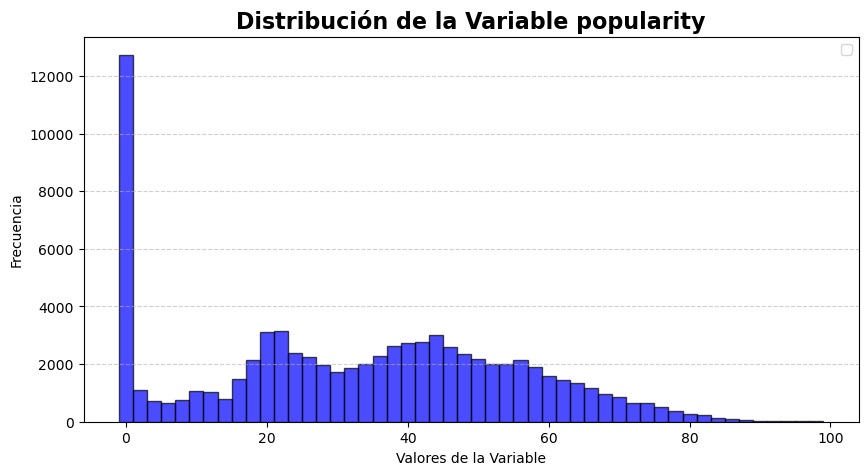

In [15]:
# Eliminar columnas que no aportan información
cols = ['track_id', 'album_name', 'track_name']
modelo.eliminar_col(cols)
dfTrain = modelo.dfTrain
xTestO = modelo.dfTest

# 📌 Eliminar filas con valores nulos en la variable objetivo
dfTrain.dropna(subset=[varRes], inplace=True)

# Eliminación de columnas con valores únicos
cols_unicas = dfTrain.nunique() == 1
dfTrain = dfTrain.loc[:, ~cols_unicas]
xTestO = xTestO.loc[:, ~cols_unicas]
print(f"✅ Se eliminaron {cols_unicas.sum()} columnas con un solo valor único.")

""" VISUALIZACIÓN Y ANÁLISIS """
# 📌 Separar variables predictoras y variable de respuesta
xTrain = dfTrain.drop(columns=[varRes])  
yTrain = dfTrain[varRes]

# 📌 Graficar variable de respuesta
modelo.graf_var(yTrain)

# Cambiar escala
xTrain['duration_ms'] = xTrain['duration_ms'].div(1000).round().astype(int)
xTrain.rename(columns={'duration_ms': 'duration_s'}, inplace=True)

xTestO['duration_ms'] = xTestO['duration_ms'].div(1000).round().astype(int)
xTestO.rename(columns={'duration_ms': 'duration_s'}, inplace=True)

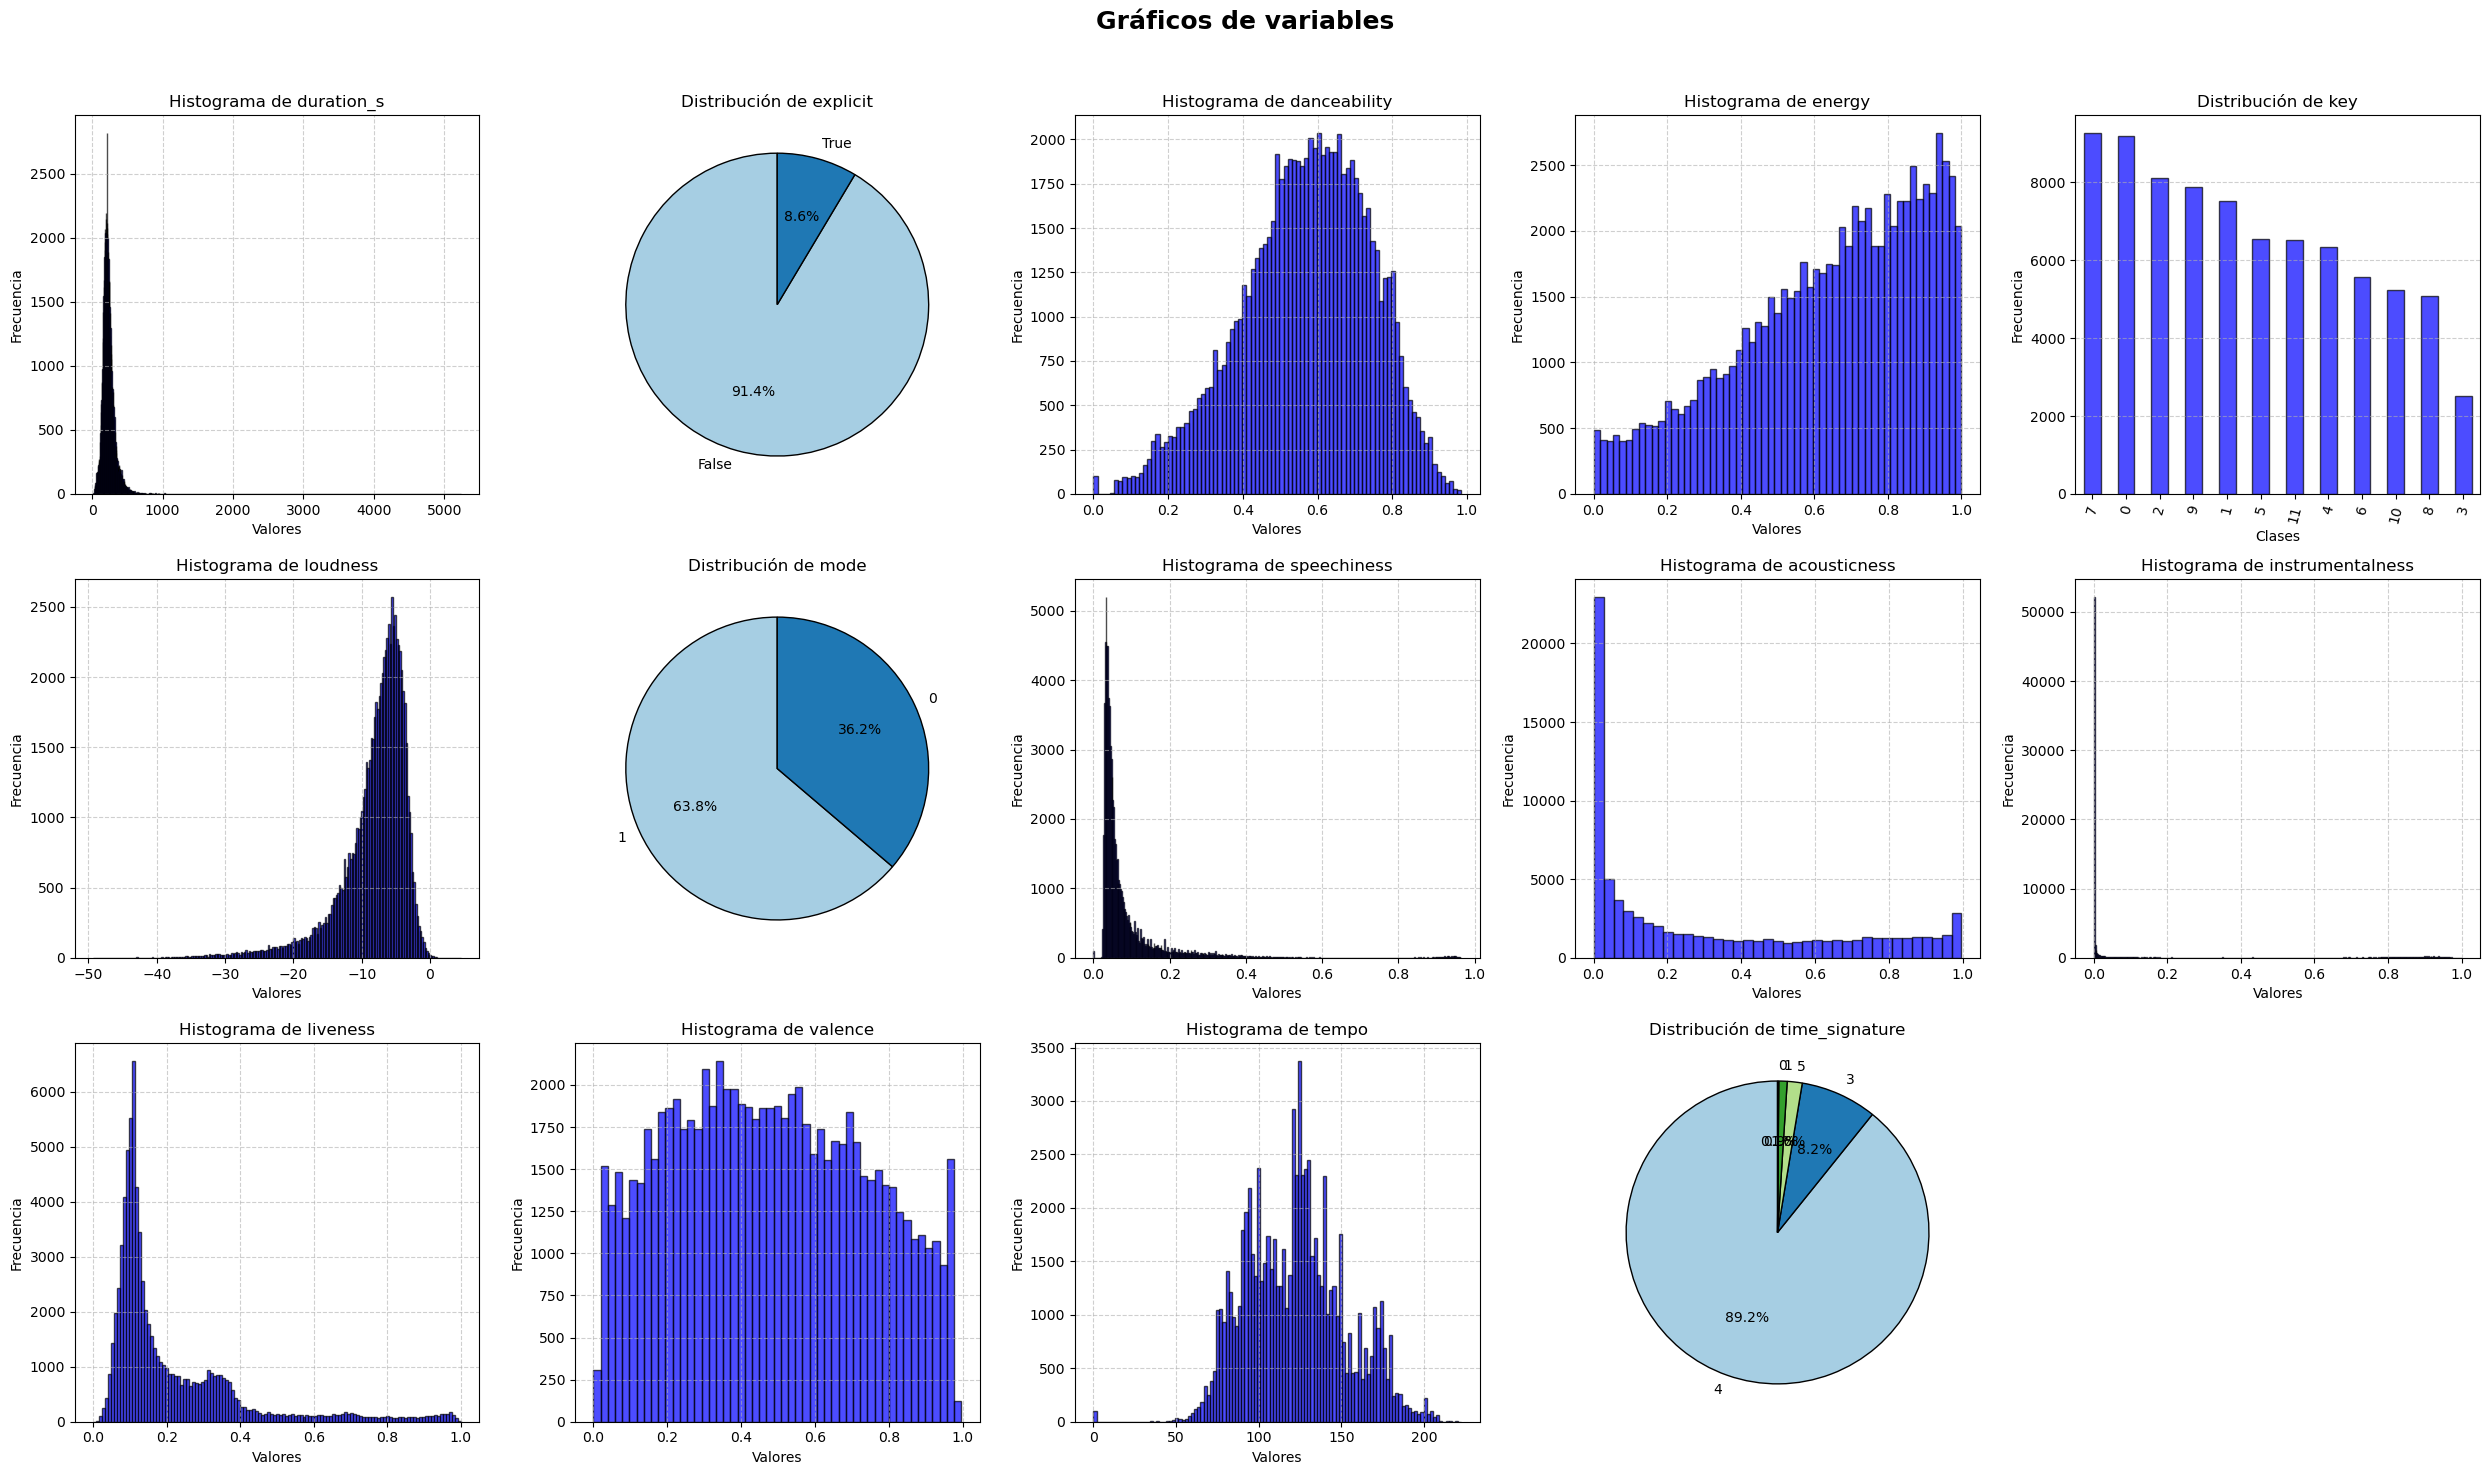

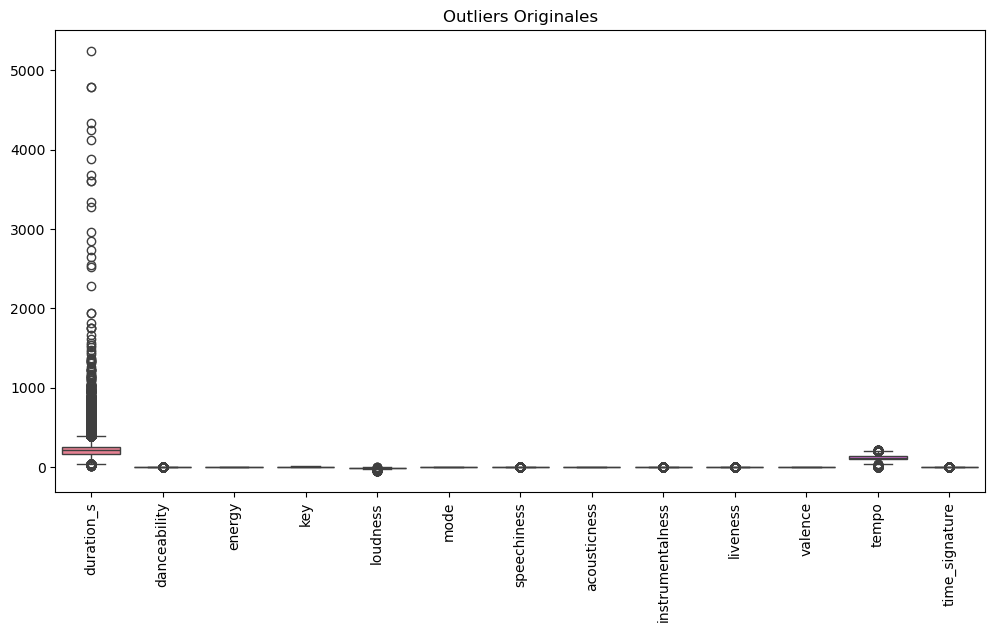

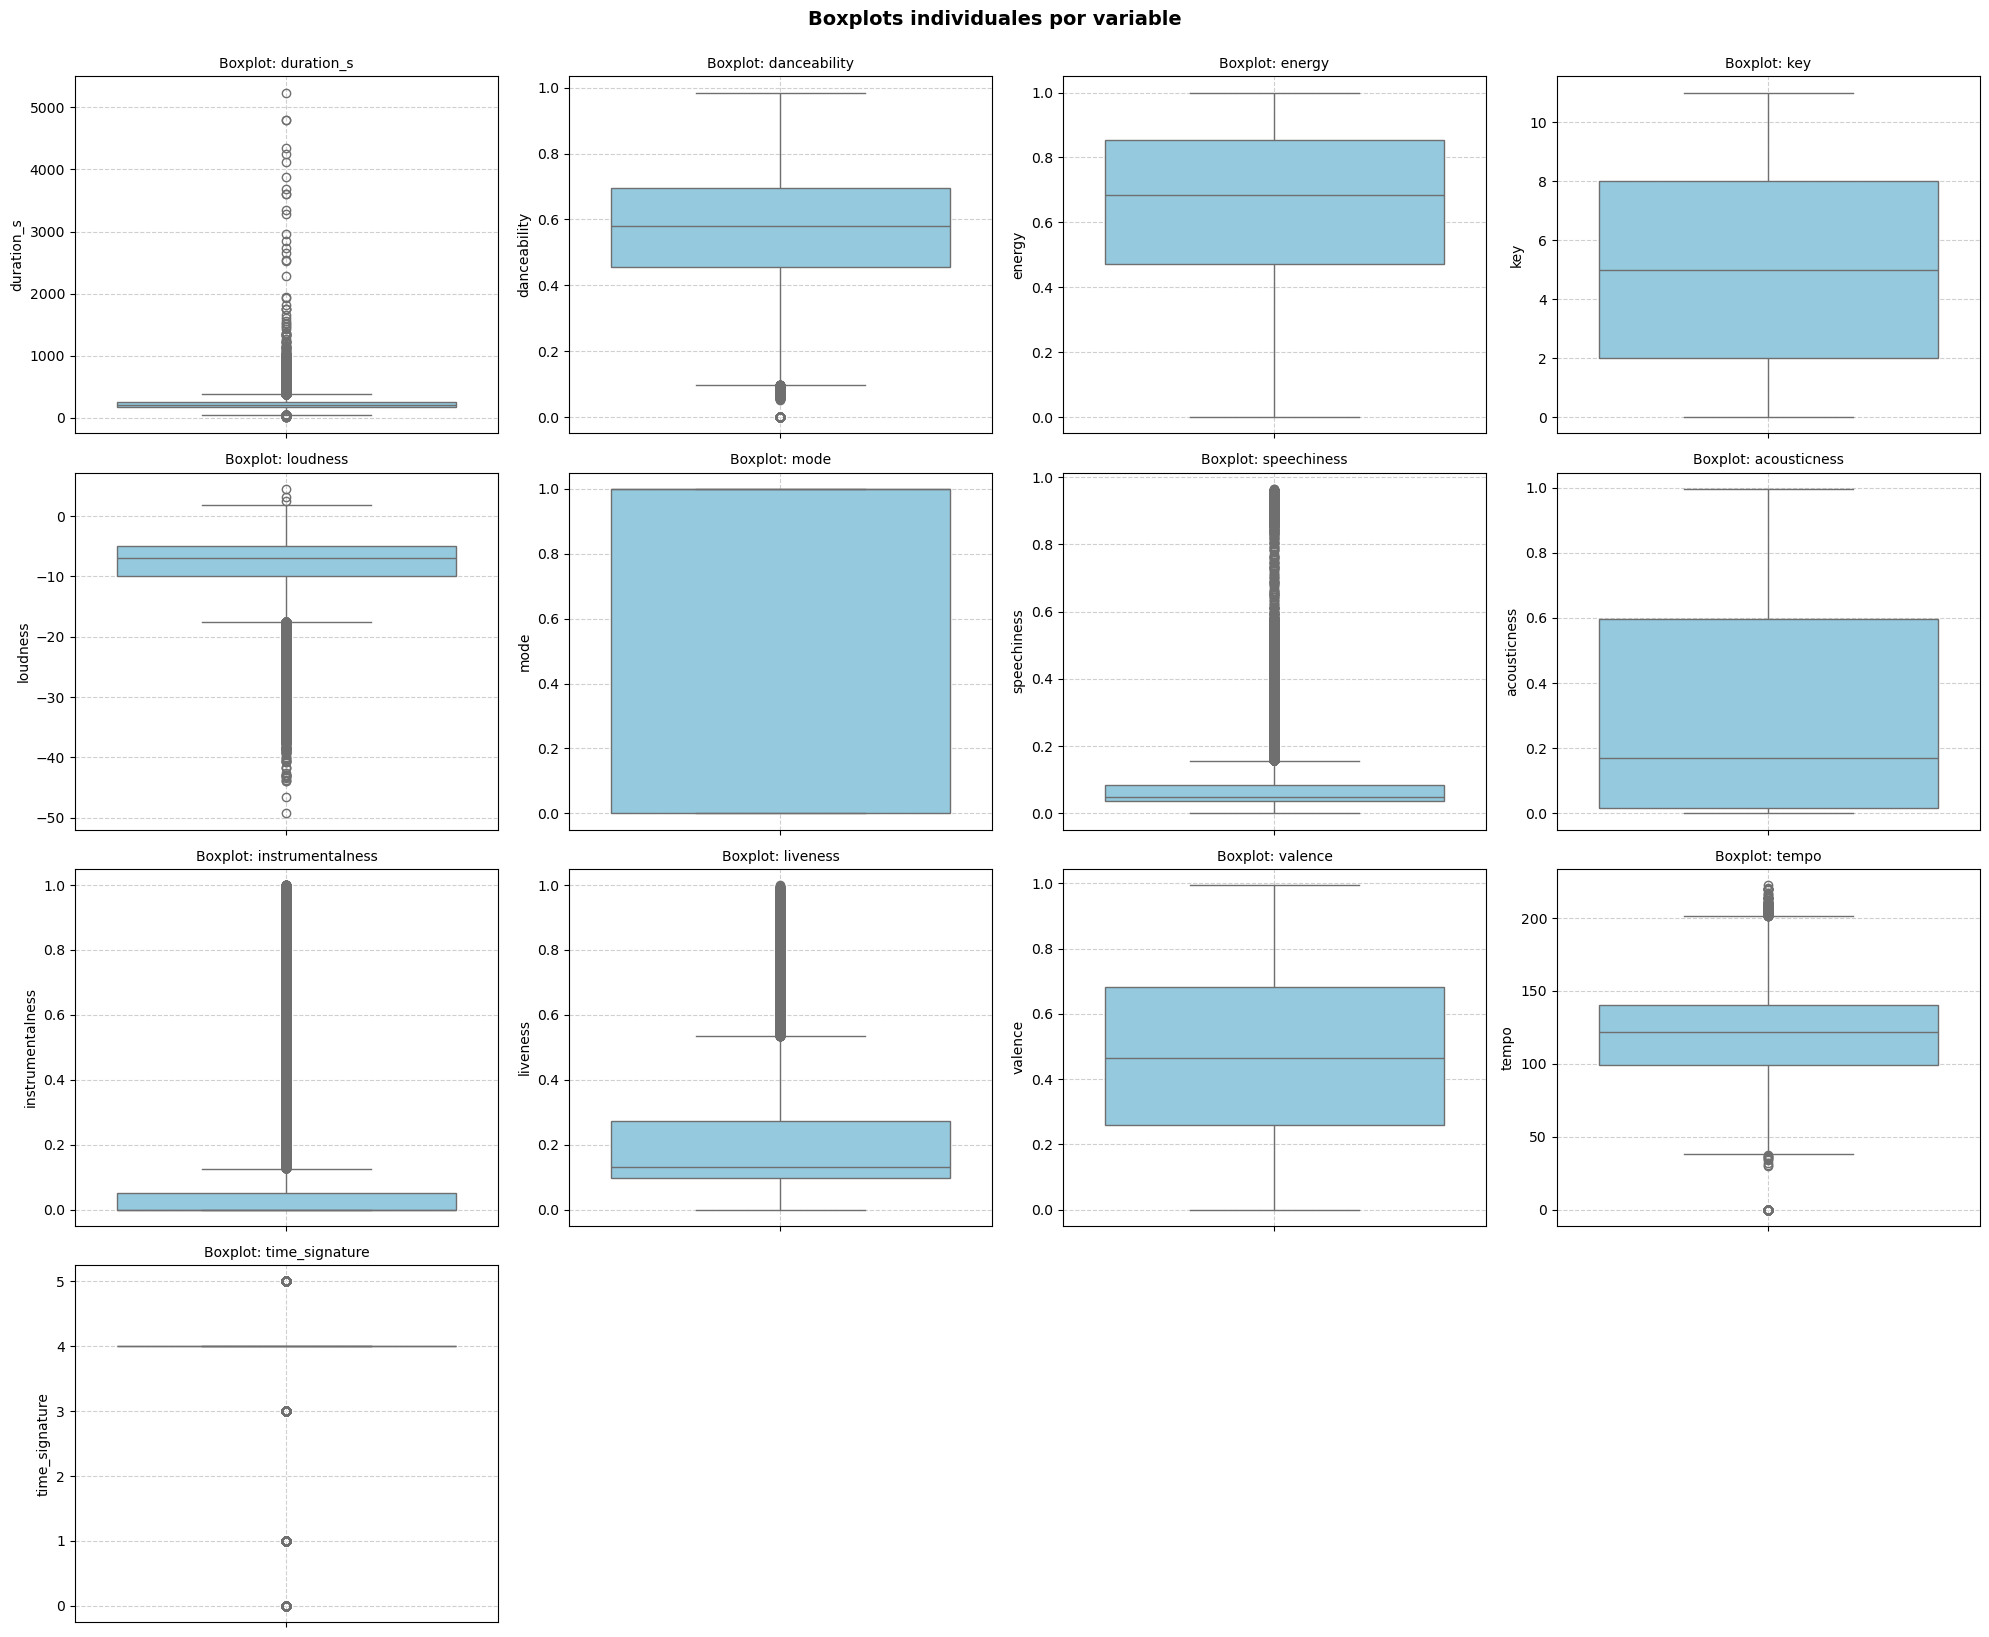


 Estadisticas de los datos numéricos:

         duration_s  danceability        energy           key      loudness  \
count  79800.000000  79800.000000  79800.000000  79800.000000  79800.000000   
mean     227.902581      0.567318      0.641529      5.307043     -8.263741   
std      105.059438      0.173110      0.251441      3.562186      5.035504   
min       13.000000      0.000000      0.000019      0.000000    -49.307000   
25%      174.000000      0.456000      0.472000      2.000000    -10.006000   
50%      213.000000      0.581000      0.685000      5.000000     -7.012000   
75%      261.000000      0.695000      0.854000      8.000000     -5.000000   
max     5237.000000      0.985000      1.000000     11.000000      4.532000   

               mode   speechiness  acousticness  instrumentalness  \
count  79800.000000  79800.000000  79800.000000      79800.000000   
mean       0.637732      0.084750      0.314979          0.157319   
std        0.480659      0.105657      0.

,Columna,Valores Nulos,Porcentaje (%)
tempo,tempo,7946,9.957393
duration_s,duration_s,7876,9.869674
loudness,loudness,1672,2.095238


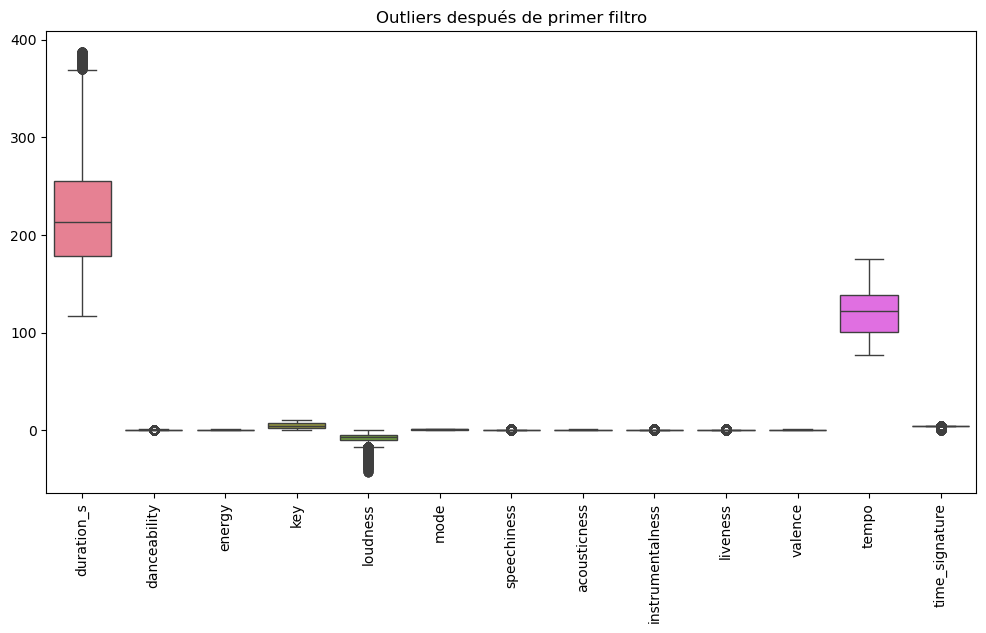

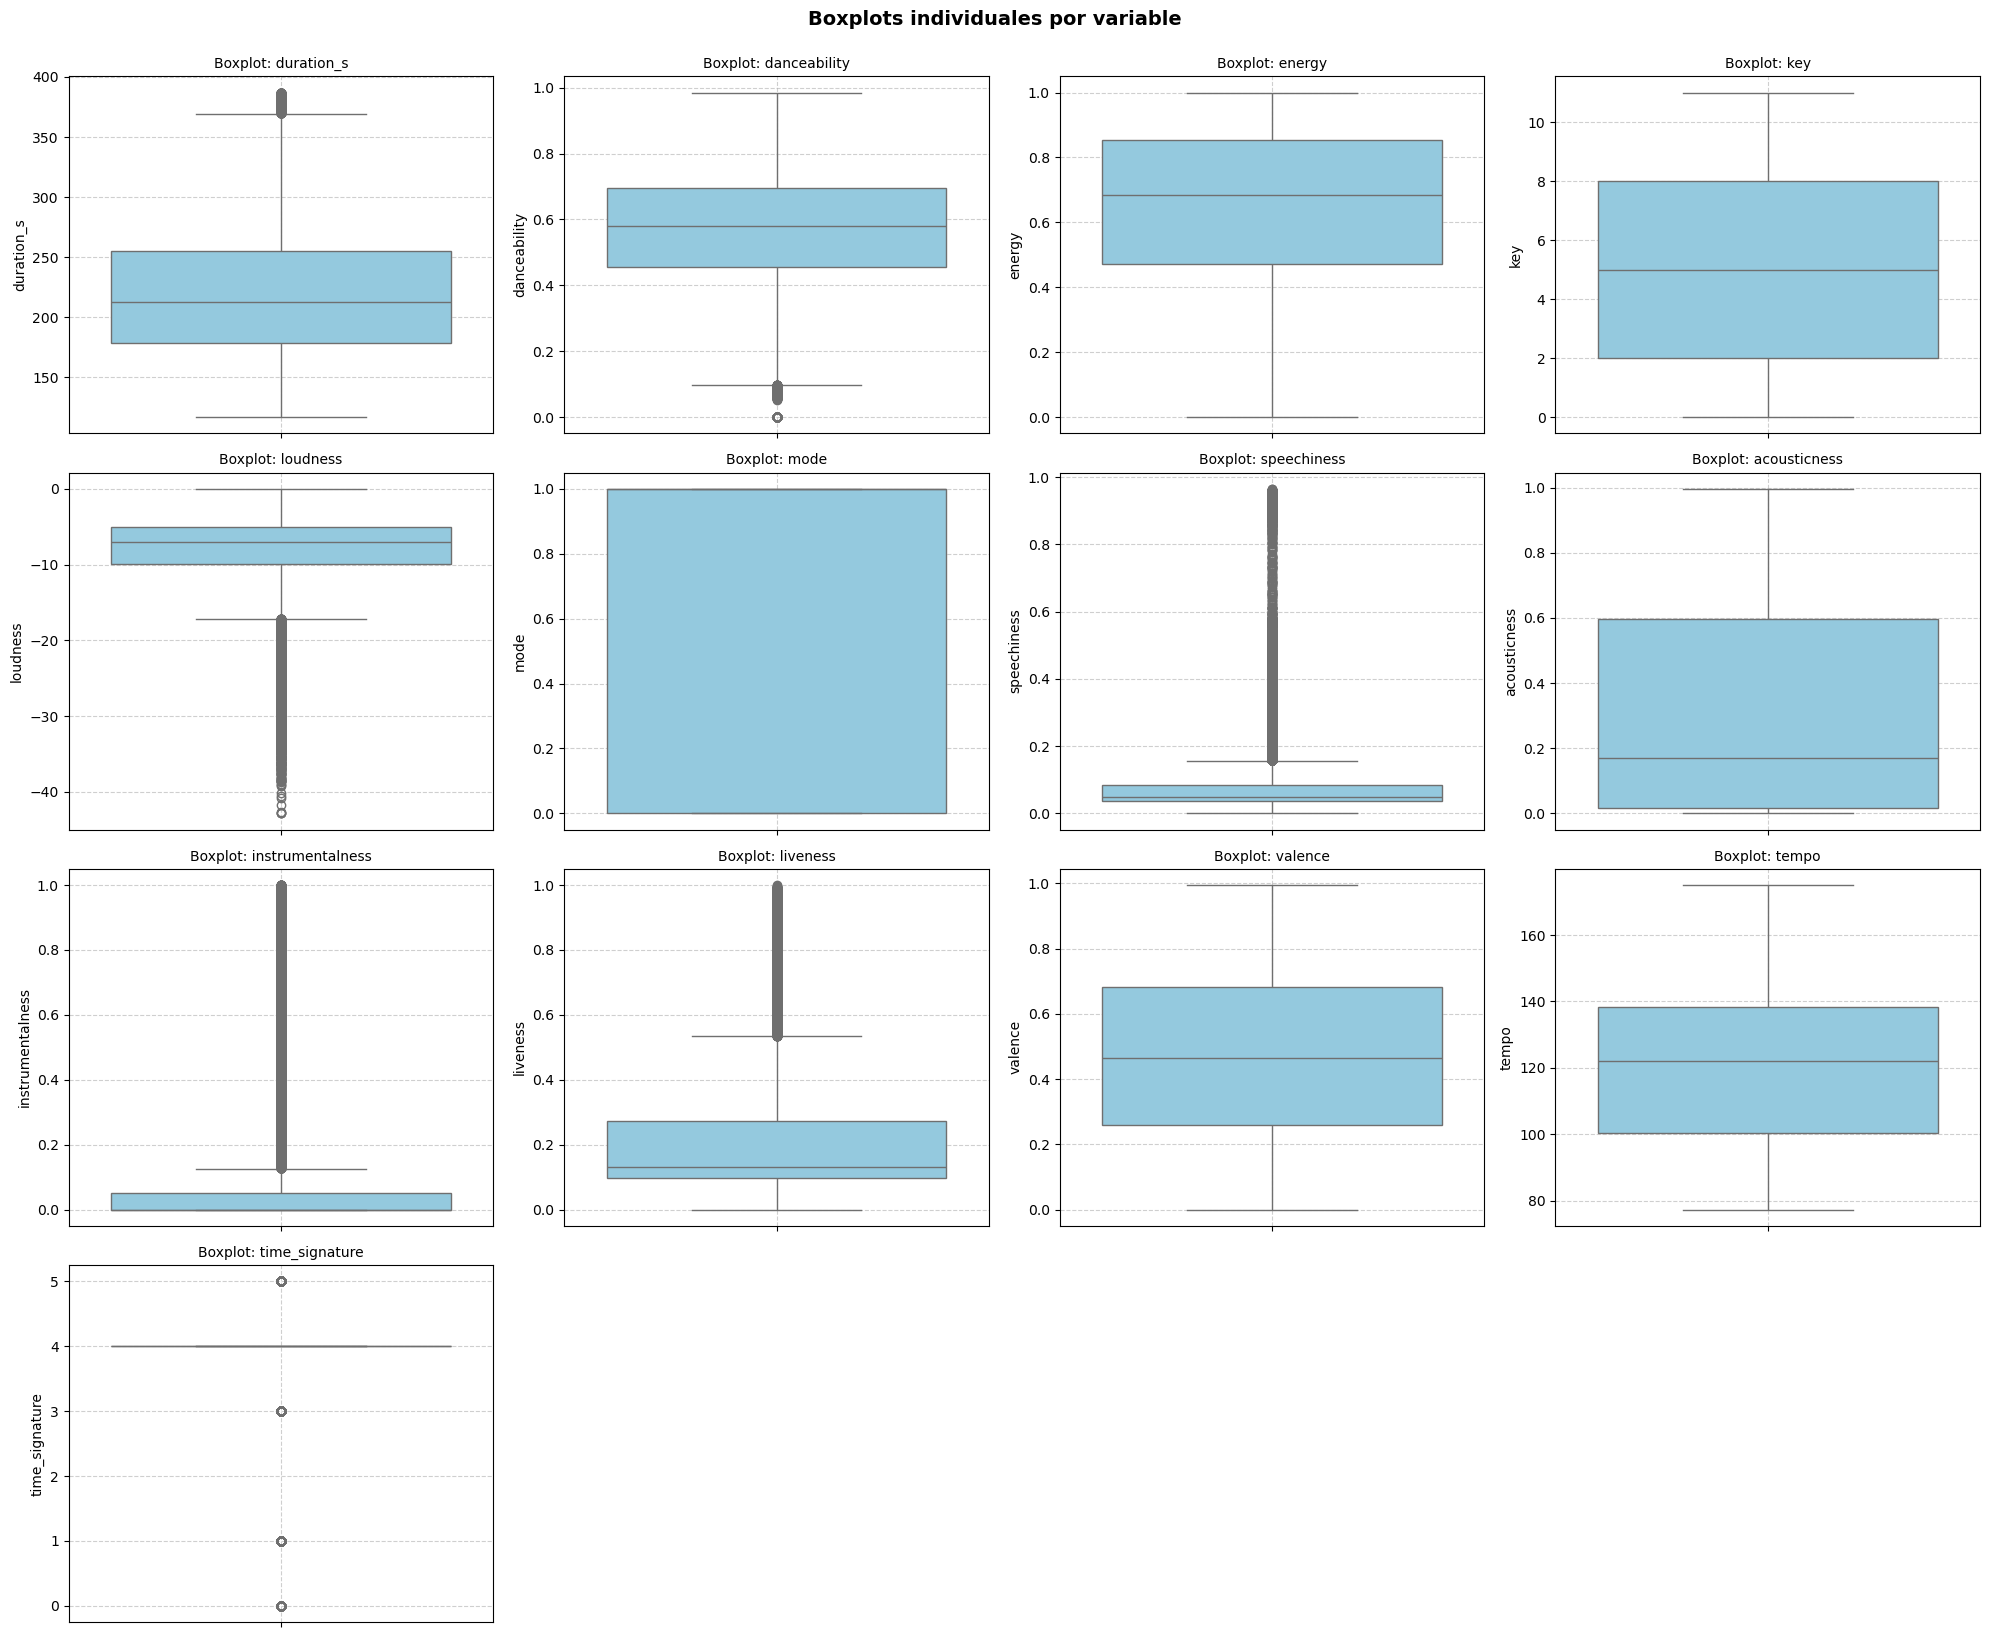


 Estadisticas de los datos numéricos:

         duration_s  danceability        energy           key      loudness  \
count  71924.000000  79800.000000  79800.000000  79800.000000  78128.000000   
mean     220.580585      0.567318      0.641529      5.307043     -8.204023   
std       57.271185      0.173110      0.251441      3.562186      4.837275   
min      117.000000      0.000000      0.000019      0.000000    -42.864000   
25%      179.000000      0.456000      0.472000      2.000000     -9.917000   
50%      213.000000      0.581000      0.685000      5.000000     -7.011000   
75%      255.000000      0.695000      0.854000      8.000000     -5.038000   
max      387.000000      0.985000      1.000000     11.000000      0.006000   

               mode   speechiness  acousticness  instrumentalness  \
count  79800.000000  79800.000000  79800.000000      79800.000000   
mean       0.637732      0.084750      0.314979          0.157319   
std        0.480659      0.105657      0.

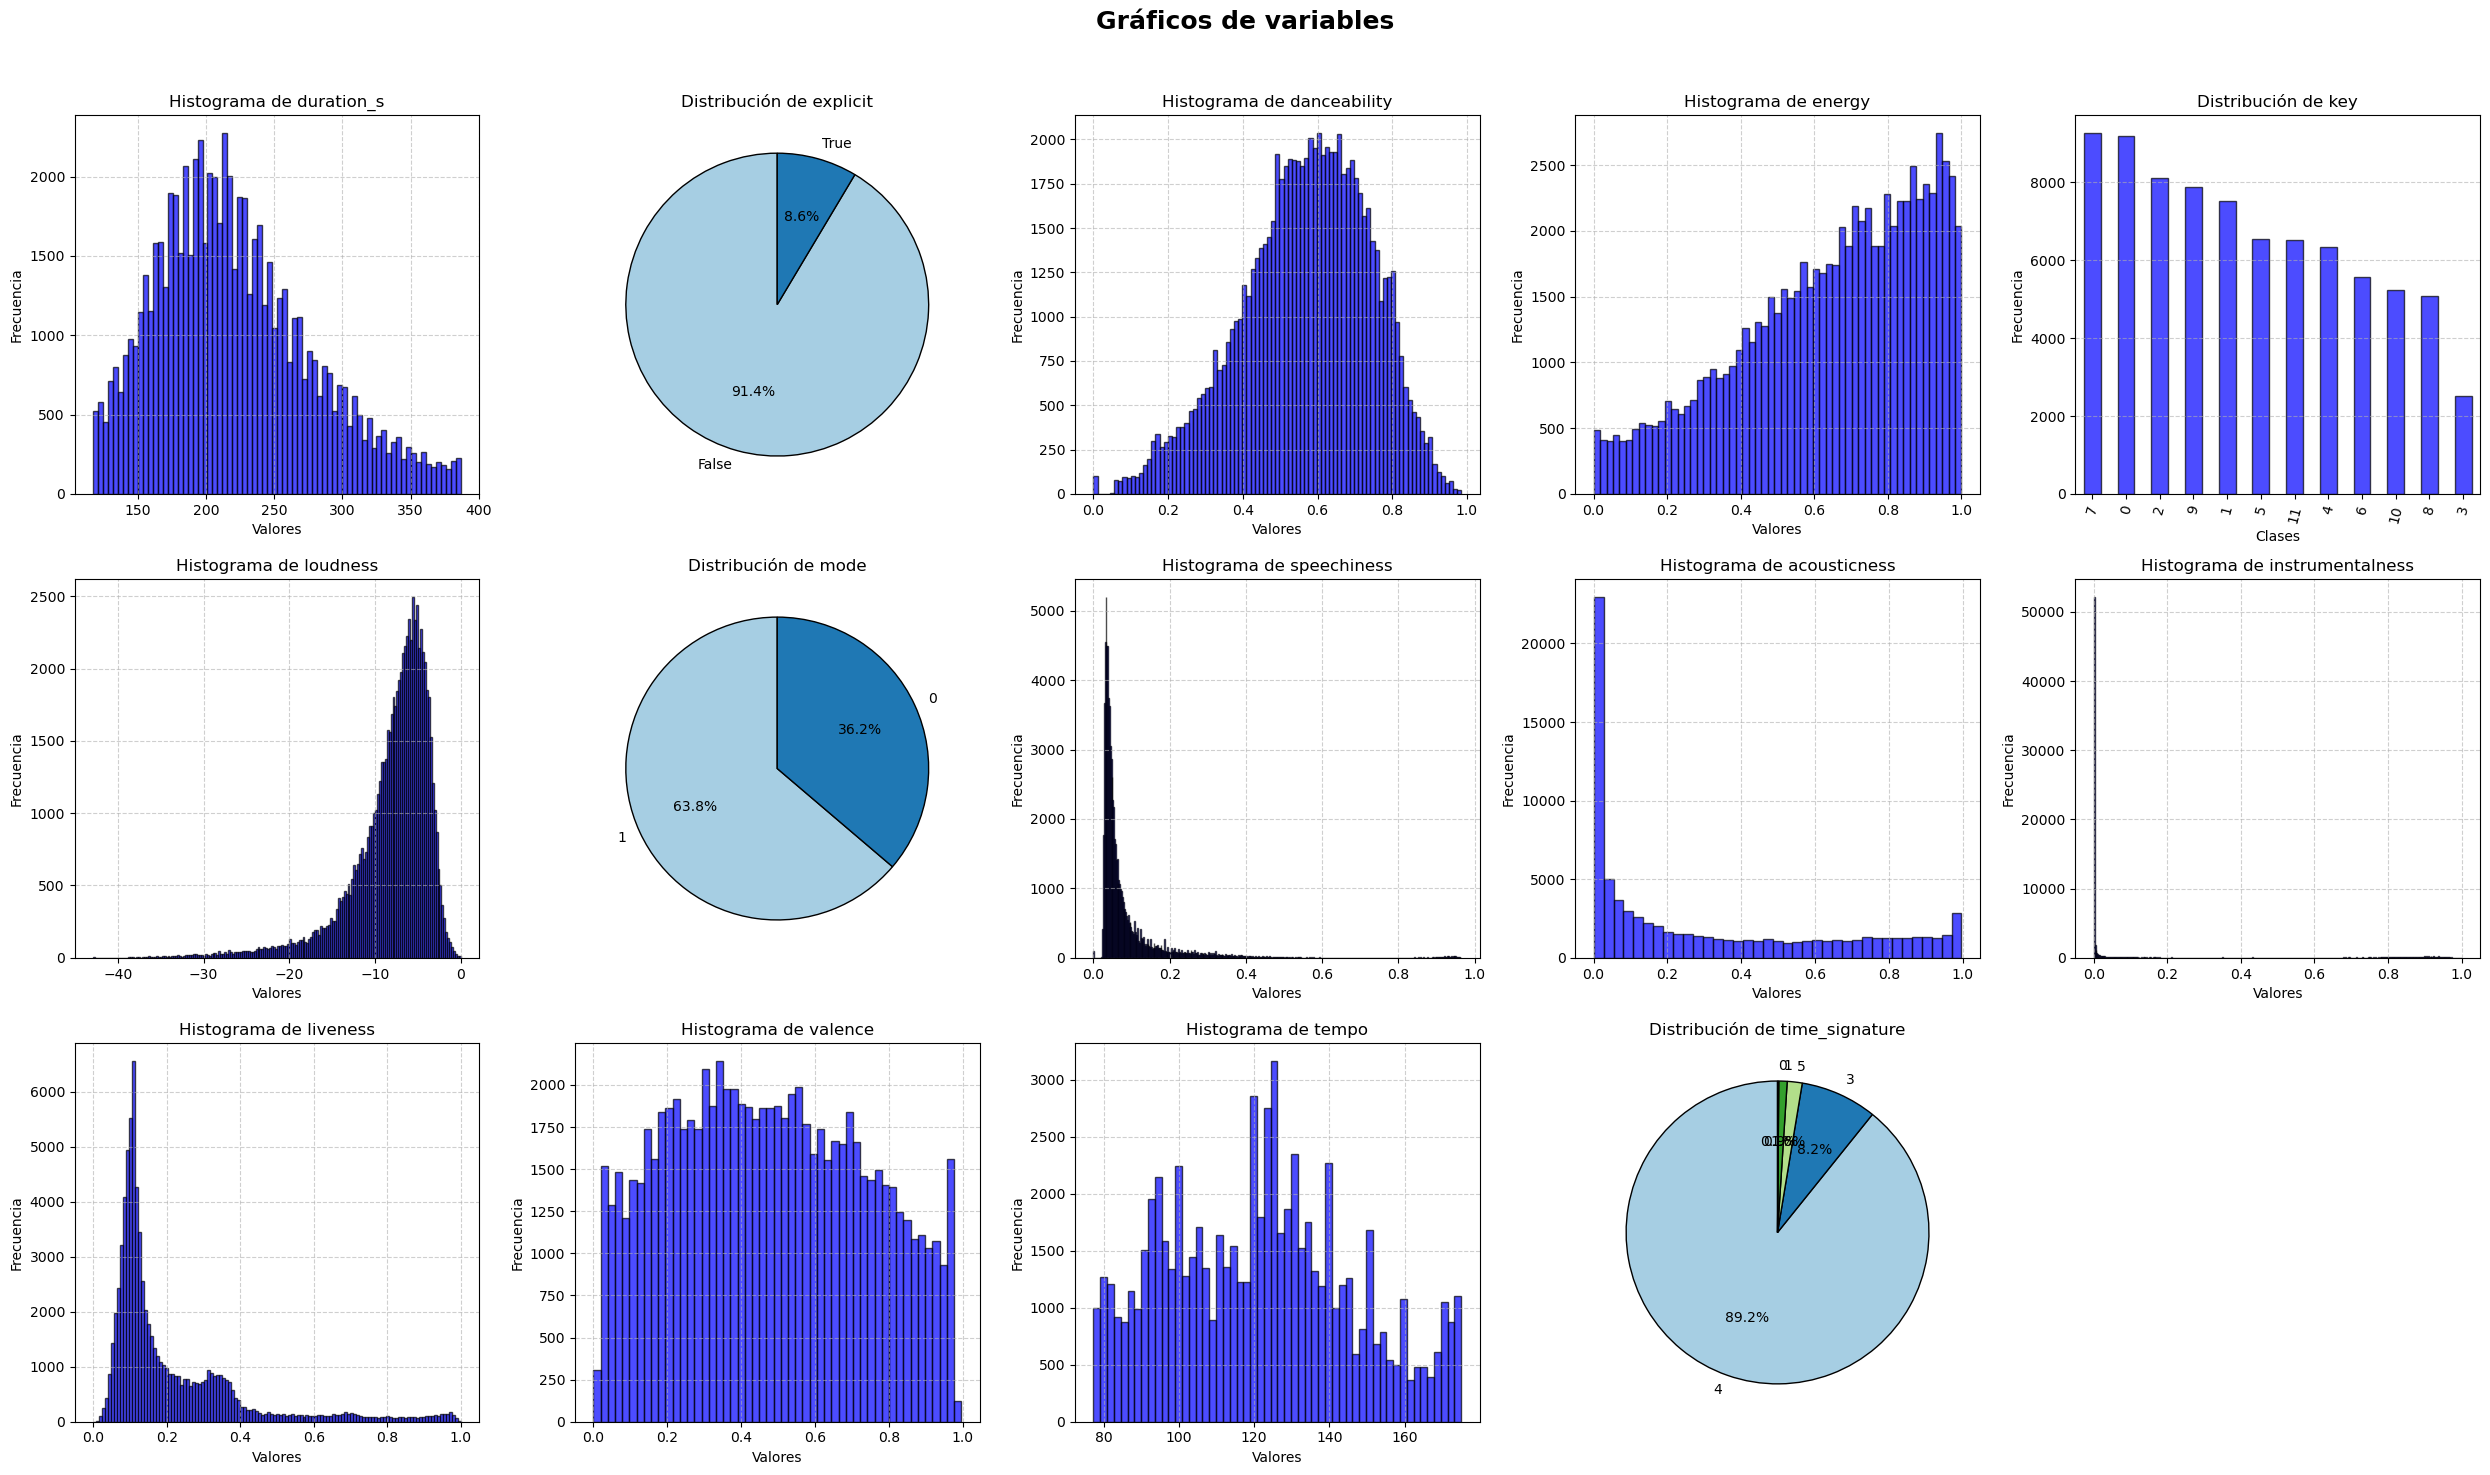

In [17]:
# Graficar los datos
modelo.graf_set(xTrain, colsGrid=5, titGraf="Gráficos de variables")

# Visualizacion
modelo.visualizar_outliers(xTrain, "Outliers Originales")

# Eliminar los valores positivos de 'Loudness'
xTrain_cleaned = xTrain.copy()
xTrain_cleaned.loc[xTrain_cleaned['loudness'] > 0, 'loudness'] = np.nan

# Eliminación inicial por rango
colFil = ['duration_s','tempo']
xTrain_cleaned, xTestO_cleaned = modelo.eliminar_outliers(xTrain, xTestO, columnas=colFil, tipoMask = 1, pInf = 0.05, pSup = 0.95)

# Eliminacion por rango para cada género de loudness
# Calcular límites inferior y superior por género
pInf = 0.01
pSup = 0.99

limInf = xTrain_cleaned.groupby('track_genre')['loudness'].quantile(pInf)
limSup = xTrain_cleaned.groupby('track_genre')['loudness'].quantile(pSup)

# Aplicar el filtro fila por fila
xTrain_cleaned['loudness'] = xTrain_cleaned.apply(
    lambda row: np.nan if (
        row['loudness'] < limInf[row['track_genre']] or
        row['loudness'] > limSup[row['track_genre']]
    ) else row['loudness'],
    axis=1
)

# Aplicar el mismo filtro a xTestO (usando límites de dfTrain)
xTestO['loudness'] = xTestO.apply(
    lambda row: np.nan if (
        row['track_genre'] in limInf and (
            row['loudness'] < limInf[row['track_genre']] or
            row['loudness'] > limSup[row['track_genre']]
        )
    ) else row['loudness'],
    axis=1
)

# Verificar valores nulos
modelo.valores_nulos(xTrain_cleaned)

# Visualizacion
modelo.visualizar_outliers(xTrain_cleaned, "Outliers después de primer filtro")

# Graficar los datos
modelo.graf_set(xTrain_cleaned, colsGrid=5, titGraf="Gráficos de variables")


🔹 Evaluando max_iter = 10...
🔹 max_iter = 10, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 20...
🔹 max_iter = 20, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 30...
🔹 max_iter = 30, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 40...
🔹 max_iter = 40, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 50...
🔹 max_iter = 50, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 60...
🔹 max_iter = 60, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 70...
🔹 max_iter = 70, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 80...
🔹 max_iter = 80, Distancia Promedio: 0.00213

🔹 Evaluando max_iter = 90...
🔹 max_iter = 90, Distancia Promedio: 0.00213


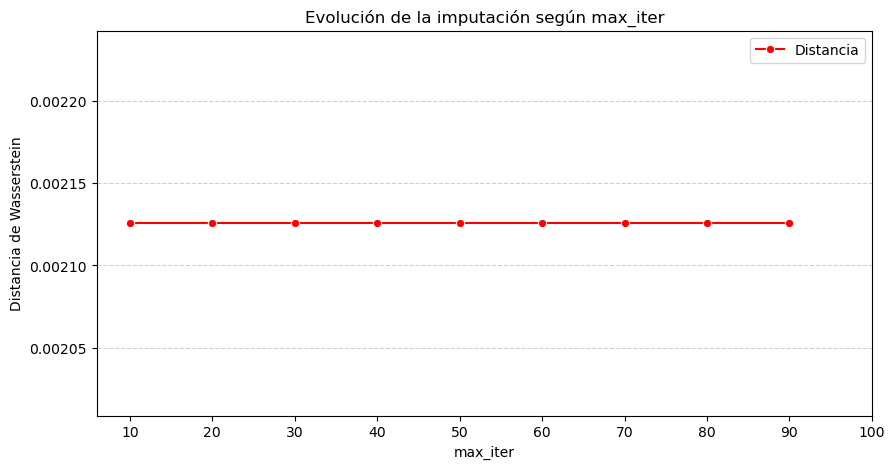


✅ Mejor max_iter: 10 🚀


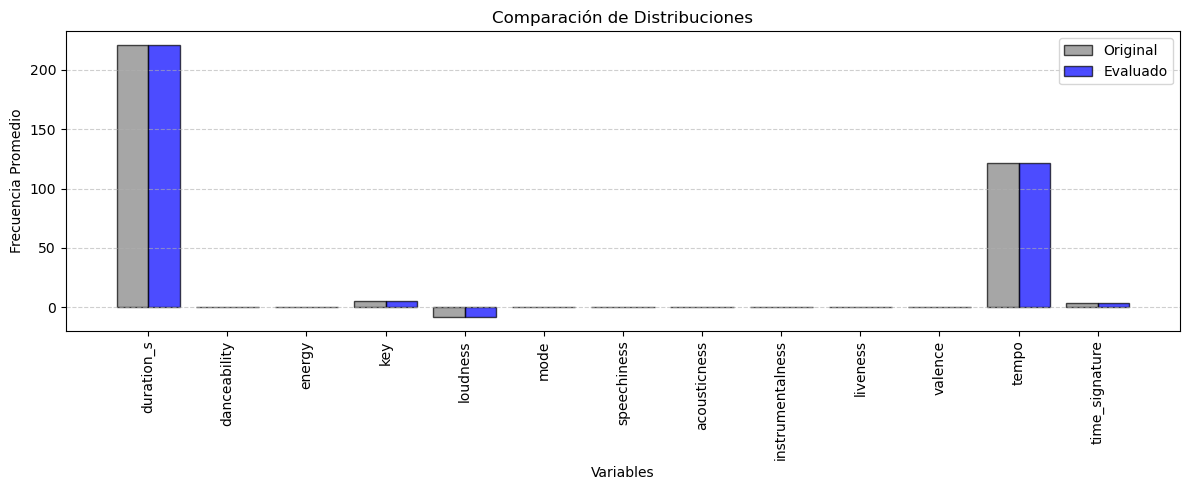


✅ No hay valores nulos en el dataset.


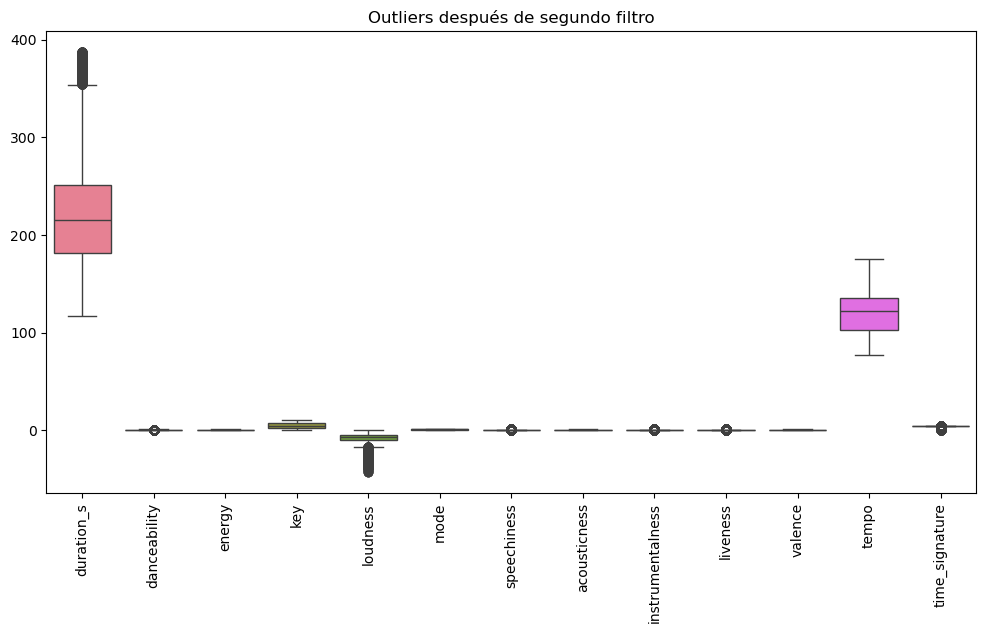

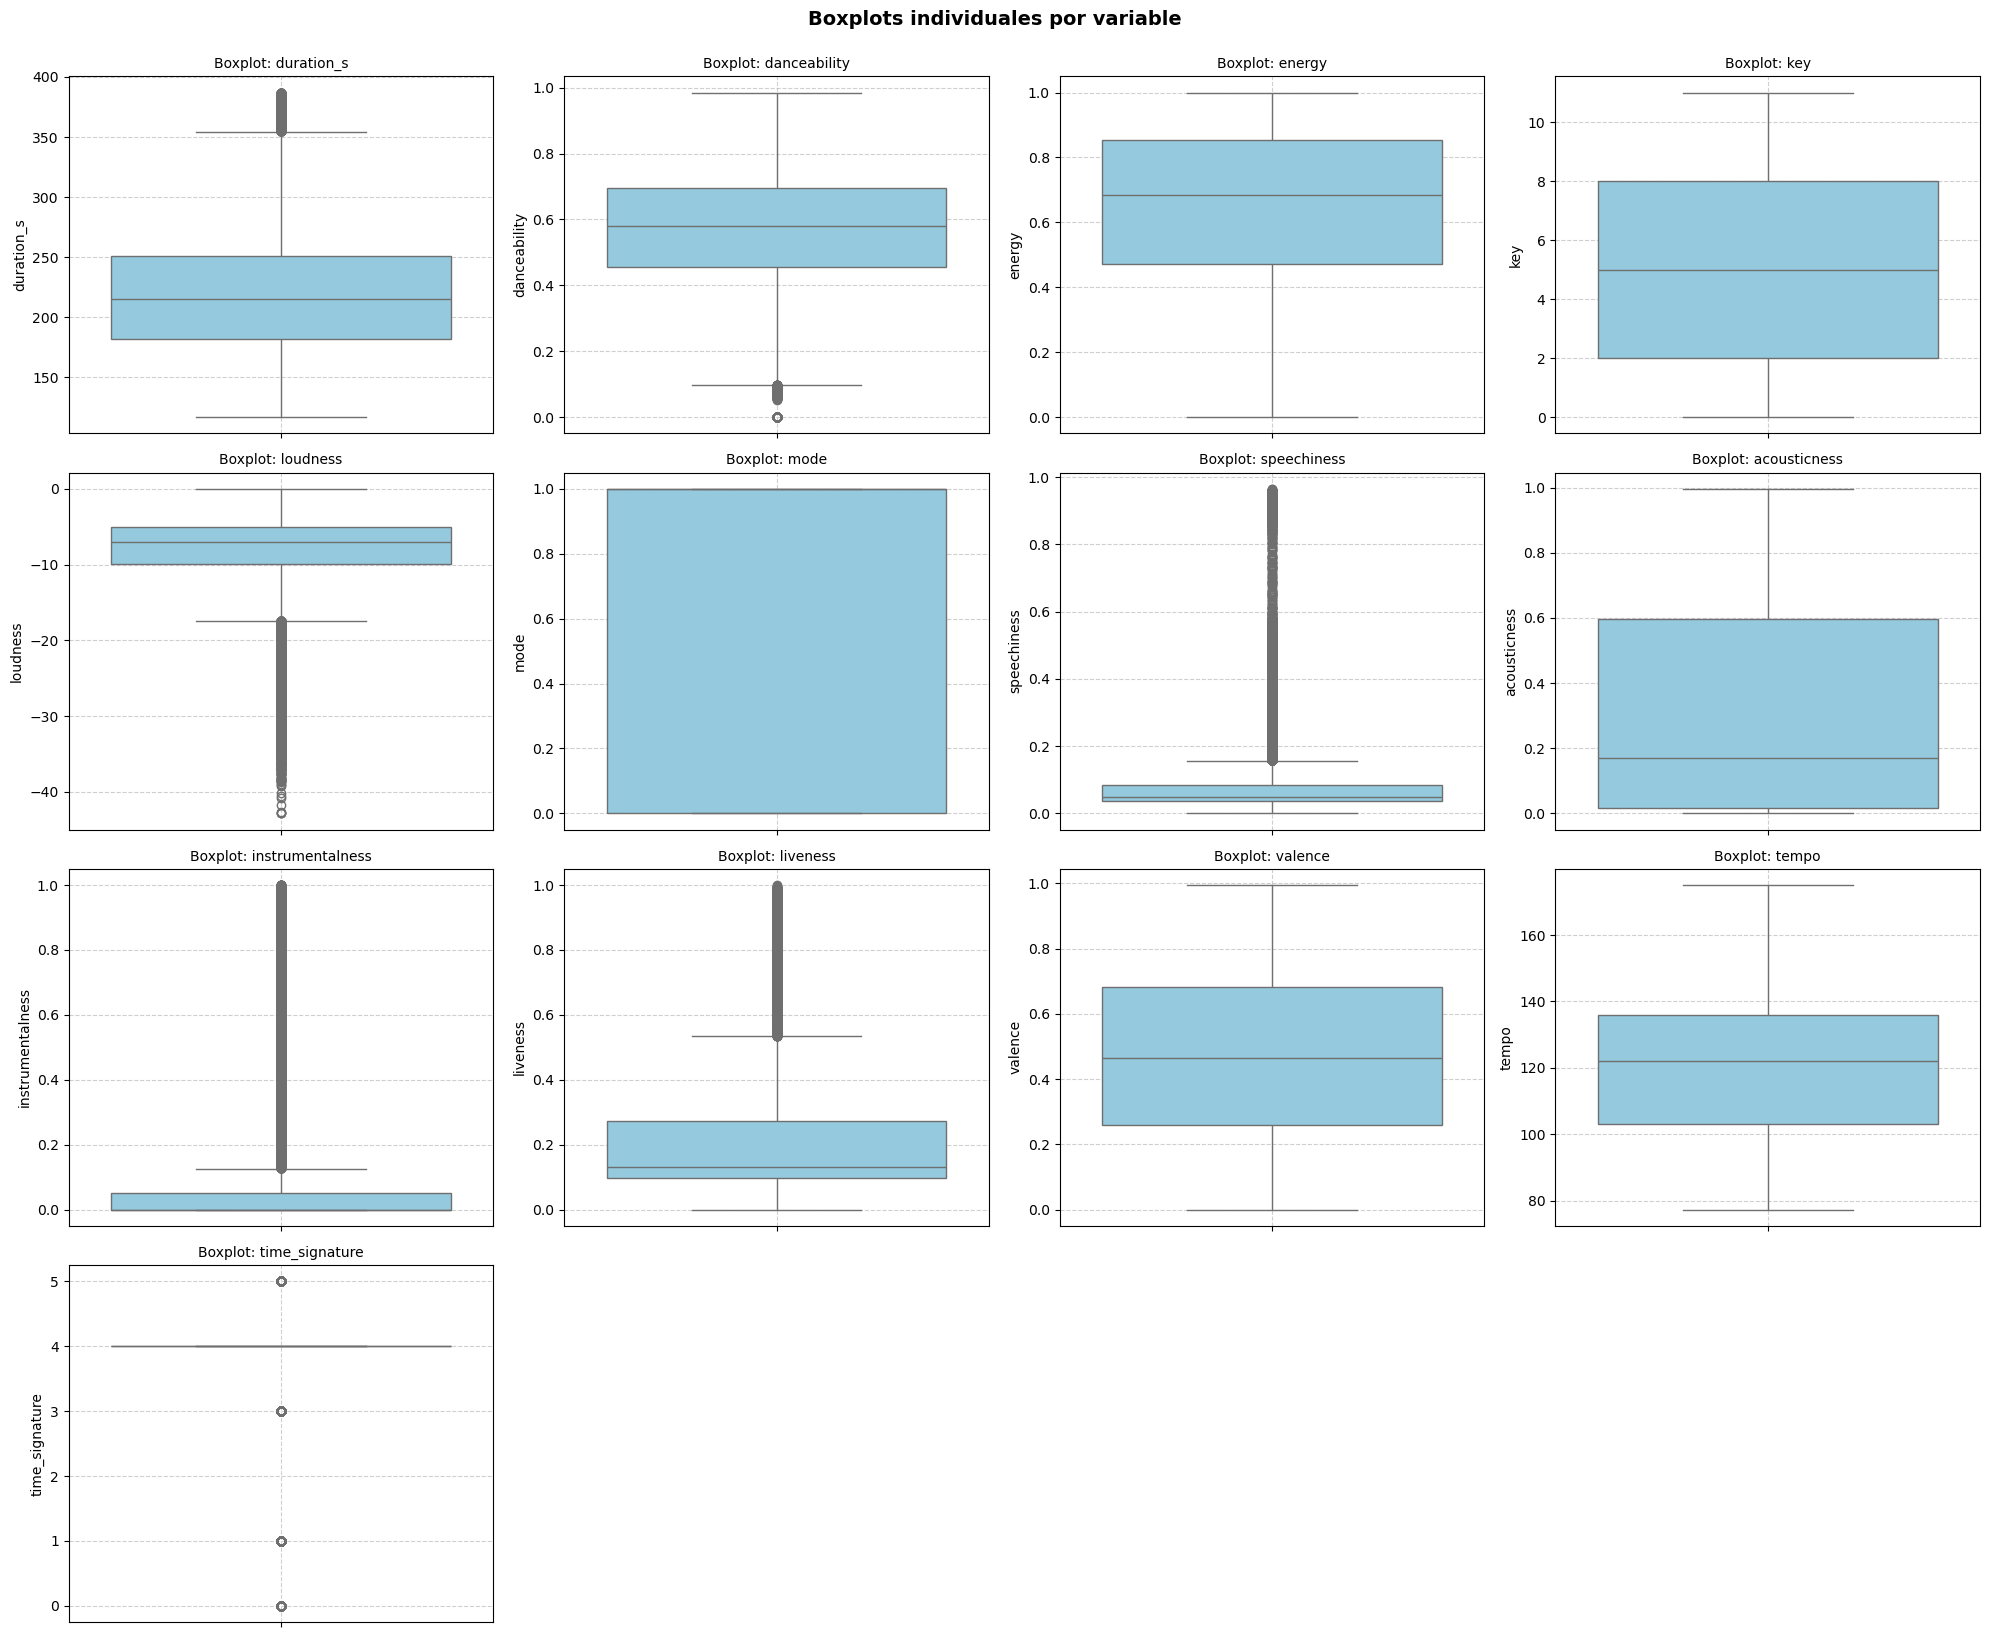


 Estadisticas de los datos numéricos:

         duration_s  danceability        energy           key      loudness  \
count  79800.000000  79800.000000  79800.000000  79800.000000  79800.000000   
mean     220.962194      0.567318      0.641529      5.307043     -8.229926   
std       54.745088      0.173110      0.251441      3.562186      4.858629   
min      117.000000      0.000000      0.000019      0.000000    -42.864000   
25%      182.000000      0.456000      0.472000      2.000000     -9.987000   
50%      215.089004      0.581000      0.685000      5.000000     -7.018000   
75%      251.000000      0.695000      0.854000      8.000000     -5.025000   
max      387.000000      0.985000      1.000000     11.000000      0.006000   

               mode   speechiness  acousticness  instrumentalness  \
count  79800.000000  79800.000000  79800.000000      79800.000000   
mean       0.637732      0.084750      0.314979          0.157319   
std        0.480659      0.105657      0.

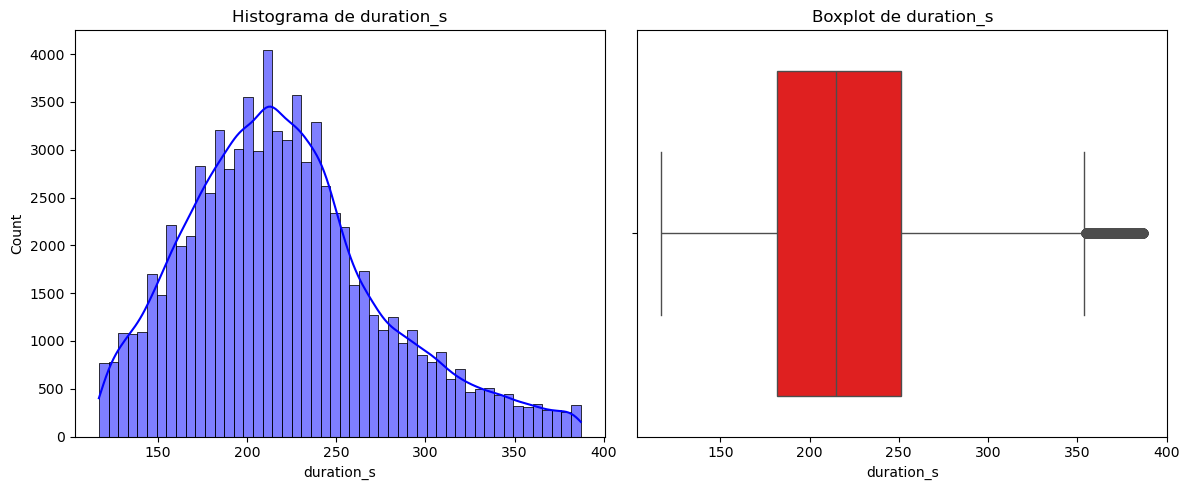


 Variables con mas correlación para duration_s:

duration_s          1.000000
instrumentalness    0.108749
energy              0.093797
tempo               0.045831
loudness            0.021812
liveness            0.012014
key                 0.011245
time_signature      0.006056
mode               -0.033734
speechiness        -0.091824
Name: duration_s, dtype: float64


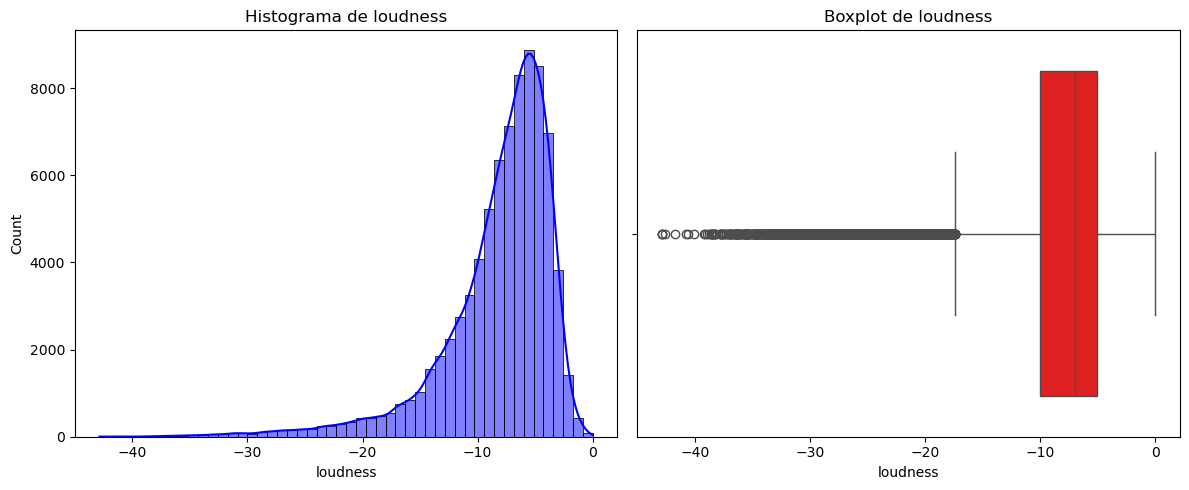


 Variables con mas correlación para loudness:

loudness          1.000000
energy            0.764301
valence           0.282137
danceability      0.262930
time_signature    0.196913
tempo             0.139064
liveness          0.077408
speechiness       0.059245
key               0.039760
duration_s        0.021812
Name: loudness, dtype: float64


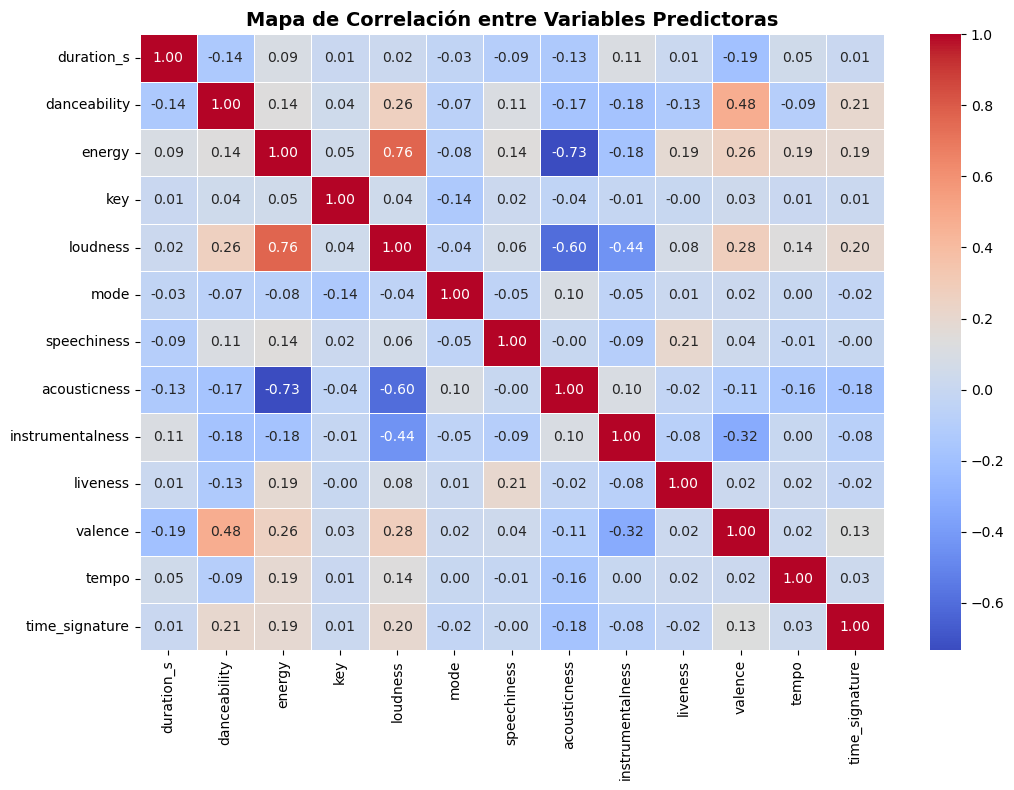

In [19]:
# Definir el mejor max_iter
iterar = True

if iterar:
    mejor_max_iter = modelo.iterar_imputacion(xTrain_cleaned, 10, 100, 10)
else:
    mejor_max_iter = 10

# Ejecutar la imputación con el mejor max_iter
xTrain_imputed, xTestO_imputed = modelo.ejecutar_imputacion(xTrain_cleaned, xTestO_cleaned, mejor_max_iter)

# Comparar la distribución antes y después de la imputación
modelo.comparar_distribuciones(xTrain_cleaned, xTrain_imputed)

# Verificar valores nulos
modelo.valores_nulos(xTrain_imputed)

# Visualizacion
modelo.visualizar_outliers(xTrain_imputed, "Outliers después de segundo filtro")

# Identificar variables problemáticas
varProm = ["duration_s", "loudness"]

# Visualizar variables problemáticas
modelo.visualizar_var(xTrain_imputed, varProm)

# **Correlograma de variables predictoras**
plt.figure(figsize=(12, 8))
sns.heatmap(xTrain_imputed.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Mapa de Correlación entre Variables Predictoras", fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 100, index=dataTesting.index, columns=['Popularity'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_file.csv', index_label='ID')
y_pred.head()